### **Problem Statement: Predict the number of bike rentals**
We have a dataset with bike rental data that contains several features including the time and date of the rental, weather conditions, and number of rentals. The dataset contains some missing values that need to be imputed, and we want to build a model to predict the number of bike rentals based on the other features.

Import the Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV


Load the Data

In [ ]:
df_raw = pd.read_csv("/content/bike_rent.csv")

In [ ]:
warnings.filterwarnings("ignore")

Get the Shape and basic Info of the data

In [ ]:
df_raw.shape


(17379, 17)

In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   instant     17379 non-null  int64 
 1   dteday      17379 non-null  object
 2   season      17379 non-null  object
 3   yr          17379 non-null  object
 4   mnth        17379 non-null  object
 5   hr          17379 non-null  int64 
 6   holiday     17379 non-null  object
 7   weekday     17379 non-null  int64 
 8   workingday  17379 non-null  object
 9   weathersit  17379 non-null  object
 10  temp        17379 non-null  object
 11  atemp       17379 non-null  object
 12  hum         17379 non-null  object
 13  windspeed   17379 non-null  object
 14  casual      17379 non-null  object
 15  registered  17379 non-null  object
 16  cnt         17379 non-null  int64 
dtypes: int64(4), object(13)
memory usage: 2.3+ MB


In [ ]:
df_raw.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2011,springer,2011,1,0,No,6,No work,Clear,0.24,0.2879,0.81,0,3,13,16
1,2,01-01-2011,springer,2011,1,1,No,6,No work,Clear,0.22,0.2727,0.8,0,8,32,40
2,3,01-01-2011,springer,2011,1,2,No,6,No work,Clear,0.22,0.2727,?,0,5,27,32
3,4,01-01-2011,springer,2011,1,3,No,6,No work,Clear,0.24,0.2879,0.75,0,3,10,13
4,5,01-01-2011,springer,2011,1,4,No,6,No work,Clear,0.24,0.2879,0.75,0,0,1,1


In [ ]:
df_raw.dtypes

instant        int64
dteday        object
season        object
yr            object
mnth          object
hr             int64
holiday       object
weekday        int64
workingday    object
weathersit    object
temp          object
atemp         object
hum           object
windspeed     object
casual        object
registered    object
cnt            int64
dtype: object

Check for missing data

In [ ]:
df_raw.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Although we are seeing 0 for missing data in each column, when we observe dataset, there some unknow/uncategorised data "?". So inorder to detect it as a missing data we have to replace ? with NaN

In [ ]:
df_raw.replace("?", float(np.nan), inplace=True)

In [ ]:
# Now check for missing data

df_raw.isnull().sum()

instant        0
dteday         0
season         6
yr             1
mnth           1
hr             0
holiday        1
weekday        0
workingday     5
weathersit     4
temp          11
atemp          6
hum            6
windspeed      5
casual         1
registered     1
cnt            0
dtype: int64

In our dataset almost all features are being detected as object. Since we have NaN values in data, when we try ro typecast object-->float64, it will throw error as "ValueError: cannot convert float NaN to integer".


So before typecasting let us handle the missing data

Let us consider datatypes as below:


instant, casual, registered,cnt --> int64

dteday --> dateTime format

season, yr, mnth, hr, holiday, weekday, workingday, weathersit --> Categorical

temp,atemp,hum,windspeed --> float64

In [ ]:
# for easy understanding let us rename the columns as below:

df_raw.rename(columns={'instant':'id','dteday':'datetime','yr':'year','mnth':'month','weathersit':'weatherCondition',
                       'hum':'humidity','casual':'unregistered', 'cnt':'total_count'},inplace=True)

In [ ]:
df_raw

,id,datetime,season,year,month,hr,holiday,weekday,workingday,weatherCondition,temp,atemp,humidity,windspeed,unregistered,registered,total_count
0,1,01-01-2011,springer,2011,1,0,No,6,No work,Clear,0.24,0.2879,0.81,0,3,13,16
1,2,01-01-2011,springer,2011,1,1,No,6,No work,Clear,0.22,0.2727,0.8,0,8,32,40
2,3,01-01-2011,springer,2011,1,2,No,6,No work,Clear,0.22,0.2727,NaN,0,5,27,32
3,4,01-01-2011,springer,2011,1,3,No,6,No work,Clear,0.24,0.2879,0.75,0,3,10,13
4,5,01-01-2011,springer,2011,1,4,No,6,No work,Clear,0.24,0.2879,0.75,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,31-12-2012,springer,2012,12,19,No,1,Working Day,Mist,0.26,0.2576,0.6,0.1642,11,108,119
17375,17376,31-12-2012,springer,2012,12,20,No,1,Working Day,Mist,0.26,0.2576,0.6,0.1642,8,81,89
17376,17377,31-12-2012,springer,2012,12,21,No,1,Working Day,Clear,NaN,0.2576,0.6,0.1642,7,83,90
17377,17378,31-12-2012,springer,2012,12,22,No,1,Working Day,Clear,0.26,0.2727,0.56,0.1343,13,48,61


In [ ]:
df_raw.isnull().sum()

id                   0
datetime             0
season               6
year                 1
month                1
hr                   0
holiday              1
weekday              0
workingday           5
weatherCondition     4
temp                11
atemp                6
humidity             6
windspeed            5
unregistered         1
registered           1
total_count          0
dtype: int64

### **Handling Missing Data**

There are many ways to handle missing data. 

1. Dropping the Rows/Columns with missing data
2. Replacing the missed slot with mean/median/mode etc..


Since in the given dataset we have very few missing data, we can drop the missing rows.

In [ ]:
df_dropped_data = df_raw.dropna()

In [ ]:
df_dropped_data

,id,datetime,season,year,month,hr,holiday,weekday,workingday,weatherCondition,temp,atemp,humidity,windspeed,unregistered,registered,total_count
0,1,01-01-2011,springer,2011,1,0,No,6,No work,Clear,0.24,0.2879,0.81,0,3,13,16
1,2,01-01-2011,springer,2011,1,1,No,6,No work,Clear,0.22,0.2727,0.8,0,8,32,40
3,4,01-01-2011,springer,2011,1,3,No,6,No work,Clear,0.24,0.2879,0.75,0,3,10,13
4,5,01-01-2011,springer,2011,1,4,No,6,No work,Clear,0.24,0.2879,0.75,0,0,1,1
5,6,01-01-2011,springer,2011,1,5,No,6,No work,Mist,0.24,0.2576,0.75,0.0896,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17370,17371,31-12-2012,springer,2012,12,15,No,1,Working Day,Mist,0.28,0.2879,0.45,0.1343,69,246,315
17373,17374,31-12-2012,springer,2012,12,18,No,1,Working Day,Mist,0.26,0.2727,0.48,0.1343,10,112,122
17374,17375,31-12-2012,springer,2012,12,19,No,1,Working Day,Mist,0.26,0.2576,0.6,0.1642,11,108,119
17375,17376,31-12-2012,springer,2012,12,20,No,1,Working Day,Mist,0.26,0.2576,0.6,0.1642,8,81,89


In [ ]:
df_dropped_data.isnull().sum()

id                  0
datetime            0
season              0
year                0
month               0
hr                  0
holiday             0
weekday             0
workingday          0
weatherCondition    0
temp                0
atemp               0
humidity            0
windspeed           0
unregistered        0
registered          0
total_count         0
dtype: int64

In [ ]:
df_dropped_data.duplicated()

0        False
1        False
3        False
4        False
5        False
         ...  
17370    False
17373    False
17374    False
17375    False
17377    False
Length: 17339, dtype: bool

In [ ]:
# Typecasting the columns as mentioned above


df_dropped_data['datetime']=pd.to_datetime(df_dropped_data.datetime)
df_dropped_data['season']=df_dropped_data.season.astype('category')
df_dropped_data['year']=df_dropped_data.year.astype('category')
df_dropped_data['month']=df_dropped_data.month.astype('int64')
df_dropped_data['hr']=df_dropped_data.hr.astype('int64')
df_dropped_data['holiday']=df_dropped_data.holiday.astype('category')
df_dropped_data['weekday']=df_dropped_data.weekday.astype('int64')
df_dropped_data['workingday']=df_dropped_data.workingday.astype('category')
df_dropped_data['weatherCondition']=df_dropped_data.weatherCondition.astype('category')
df_dropped_data['temp']=df_dropped_data.temp.astype('float64')
df_dropped_data['atemp']=df_dropped_data.atemp.astype('float64')
df_dropped_data['humidity']=df_dropped_data.humidity.astype('float64')
df_dropped_data['windspeed']=df_dropped_data.windspeed.astype('float64')
df_dropped_data['unregistered']=df_dropped_data.unregistered.astype('float64')
df_dropped_data['registered']=df_dropped_data.registered.astype('float64')



In [ ]:
df_dropped_data.dtypes

id                           int64
datetime            datetime64[ns]
season                    category
year                      category
month                        int64
hr                           int64
holiday                   category
weekday                      int64
workingday                category
weatherCondition          category
temp                       float64
atemp                      float64
humidity                   float64
windspeed                  float64
unregistered               float64
registered                 float64
total_count                  int64
dtype: object

In [ ]:
for col in df_dropped_data.select_dtypes(include=['category']):
    counts = df_dropped_data[col].value_counts()
    print(f"Unique entries and counts for {col}:\n{counts}\n")

Unique entries and counts for season:
fall        4496
summer      4409
winter      4232
springer    4202
Name: season, dtype: int64

Unique entries and counts for year:
2012    8710
2011    8629
Name: year, dtype: int64

Unique entries and counts for holiday:
No     16845
Yes      494
Name: holiday, dtype: int64

Unique entries and counts for workingday:
Working Day    11844
No work         5495
Name: workingday, dtype: int64

Unique entries and counts for weatherCondition:
Clear         11400
Mist           4522
Light Snow     1414
Heavy Rain        3
Name: weatherCondition, dtype: int64



We can see that the above info indicated that the categories in any column is not execeeding 10 unique entries. So no need to take any special care on Categorical data. 

We can perform Ordinal or OneHot encoding for the data.


In [ ]:
# Get list of categorical Columns

df_cat_col = df_dropped_data.select_dtypes(include='category').columns


# taking copy
df_data_encoded = df_dropped_data.copy()

# create a dictionary to map encoded values back to category values
reverse_encodings = {}

# apply label encoding starting from 1 to each categorical column
for column in df_cat_col:
    encoder = LabelEncoder()
    encoder.fit(df_data_encoded[column])
    df_data_encoded[column] = encoder.transform(df_data_encoded[column]) + 1
    reverse_encodings[column] = {k: v for k, v in zip(encoder.transform(encoder.classes_) + 1, encoder.classes_)}


df_data_encoded
# print the reverse encodings
print(reverse_encodings)

{'season': {1: 'fall', 2: 'springer', 3: 'summer', 4: 'winter'}, 'year': {1: '2011', 2: '2012'}, 'holiday': {1: 'No', 2: 'Yes'}, 'workingday': {1: 'No work', 2: 'Working Day'}, 'weatherCondition': {1: 'Clear', 2: 'Heavy Rain', 3: 'Light Snow', 4: 'Mist'}}


'season': 1: 'fall', 2: 'springer', 3: 'summer', 4: 'winter'

'year': 1: '2011', 2: '2012'

'holiday': 1: 'No', 2: 'Yes'

'workingday': 1: 'No work', 2: 'Working Day'

'weatherCondition': 1: 'Clear', 2: 'Heavy Rain', 3: 'Light Snow', 4: 'Mist'

In [ ]:
df_data_encoded.dtypes

id                           int64
datetime            datetime64[ns]
season                       int64
year                         int64
month                        int64
hr                           int64
holiday                      int64
weekday                      int64
workingday                   int64
weatherCondition             int64
temp                       float64
atemp                      float64
humidity                   float64
windspeed                  float64
unregistered               float64
registered                 float64
total_count                  int64
dtype: object

In [ ]:
df_data_encoded

,id,datetime,season,year,month,hr,holiday,weekday,workingday,weatherCondition,temp,atemp,humidity,windspeed,unregistered,registered,total_count
0,1,2011-01-01,2,1,1,0,1,6,1,1,0.24,0.2879,0.81,0.0000,3.0,13.0,16
1,2,2011-01-01,2,1,1,1,1,6,1,1,0.22,0.2727,0.80,0.0000,8.0,32.0,40
3,4,2011-01-01,2,1,1,3,1,6,1,1,0.24,0.2879,0.75,0.0000,3.0,10.0,13
4,5,2011-01-01,2,1,1,4,1,6,1,1,0.24,0.2879,0.75,0.0000,0.0,1.0,1
5,6,2011-01-01,2,1,1,5,1,6,1,4,0.24,0.2576,0.75,0.0896,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17370,17371,2012-12-31,2,2,12,15,1,1,2,4,0.28,0.2879,0.45,0.1343,69.0,246.0,315
17373,17374,2012-12-31,2,2,12,18,1,1,2,4,0.26,0.2727,0.48,0.1343,10.0,112.0,122
17374,17375,2012-12-31,2,2,12,19,1,1,2,4,0.26,0.2576,0.60,0.1642,11.0,108.0,119
17375,17376,2012-12-31,2,2,12,20,1,1,2,4,0.26,0.2576,0.60,0.1642,8.0,81.0,89


Basic Visualizations

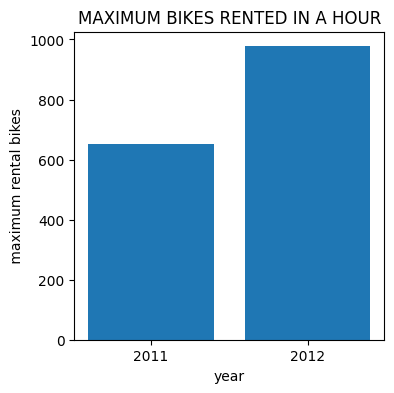

In [ ]:
plt.figure(figsize=(4,4))
plt.bar(df_data_encoded["year"],df_data_encoded["total_count"])
plt.ylabel(' maximum rental bikes ')
plt.xlabel('year')
plt.title("MAXIMUM BIKES RENTED IN A HOUR")
plt.xticks([1,2],['2011', '2012'])
plt.show()

INSIGHTS:

MAX Numbers of bikes rented in a hour is more in 2012 when compared to 2011

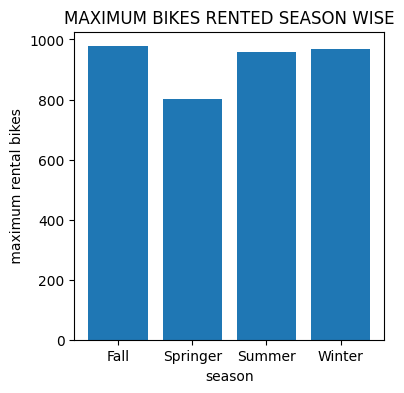

In [ ]:
plt.figure(figsize=(4,4))
plt.bar(df_data_encoded["season"],df_data_encoded["total_count"])
plt.ylabel(' maximum rental bikes ')
plt.xlabel('season')
plt.title("MAXIMUM BIKES RENTED SEASON WISE")
plt.xticks([1,2,3,4],['Fall', 'Springer', 'Summer', 'Winter'])
plt.show()

INSIGHTS:

1. Fall Season
2. Springer
3. Summer
4. Winter


From Above Graph we can get info that More Bikes were rented in Fall season

INSIGHTS:

Peak Season was Fall in both years 2011 and 2012

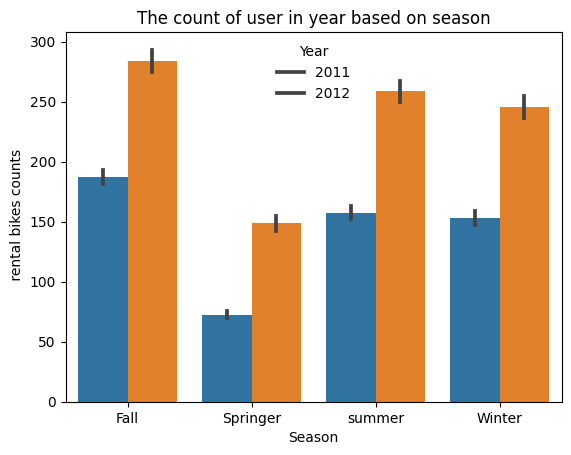

In [ ]:
b = sns.barplot(x="season",y="total_count",data=df_data_encoded,hue="year")
plt.ylabel(' rental bikes counts')
plt.xlabel('Season')
plt.title("The count of user in year based on season")
plt.xticks([0,1,2,3],['Fall', 'Springer', 'summer', 'Winter'])
plt.legend(title='Year', loc='best', labels=['2011', '2012'], frameon=False)
plt.show(b);

INSIGHT :
Peak season was fall season since average rental bike was maximum in Fall season for both years

In [ ]:
z=df_data_encoded.groupby(["month"])["total_count"].agg(["sum"])
z.sort_values(by="sum",ascending=False)

,sum
month,
8,351194
6,346342
9,345991
7,344948
5,331686
10,322352
4,269094
11,254831
3,228920


INSIGHTS:

Peak Month for the Bike rentals is 8th Month - August
And in Jan we have less count of Bike Rentals.

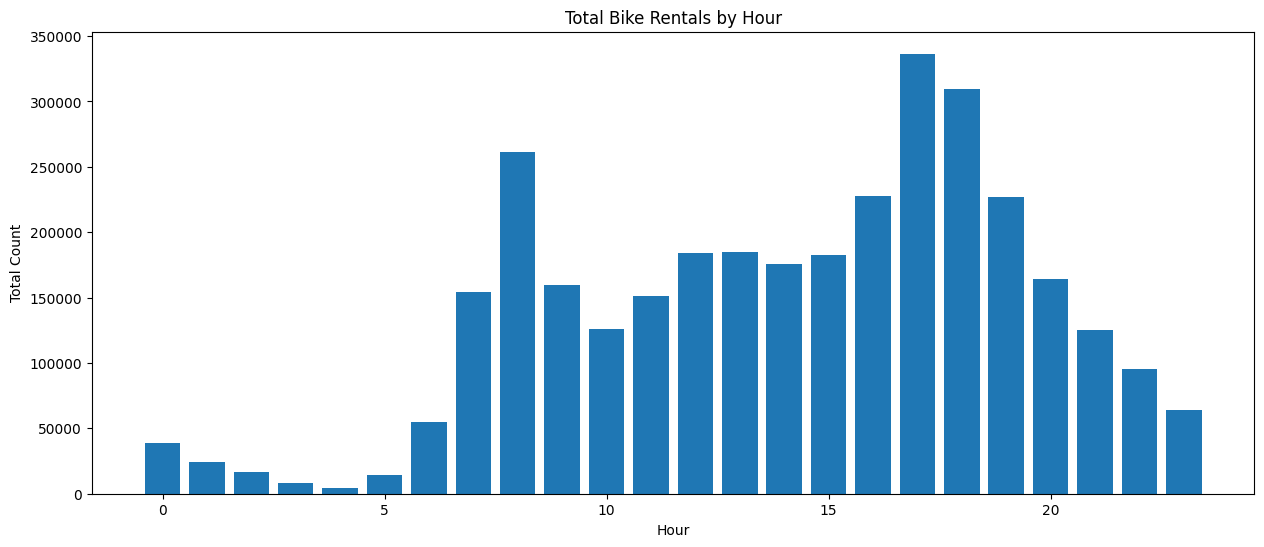

In [ ]:
x=df_data_encoded.groupby(["hr"])["total_count"].agg(["sum"])
# create a bar plot
plt.figure(figsize=(15,6))
plt.bar(x.index, x["sum"])
plt.xlabel("Hour")
plt.ylabel("Total Count")
plt.title("Total Bike Rentals by Hour")
plt.show()

INSIGHT :
Demand of bikes at 5 pm(17) was maximum so peak time was 5 pm in evening

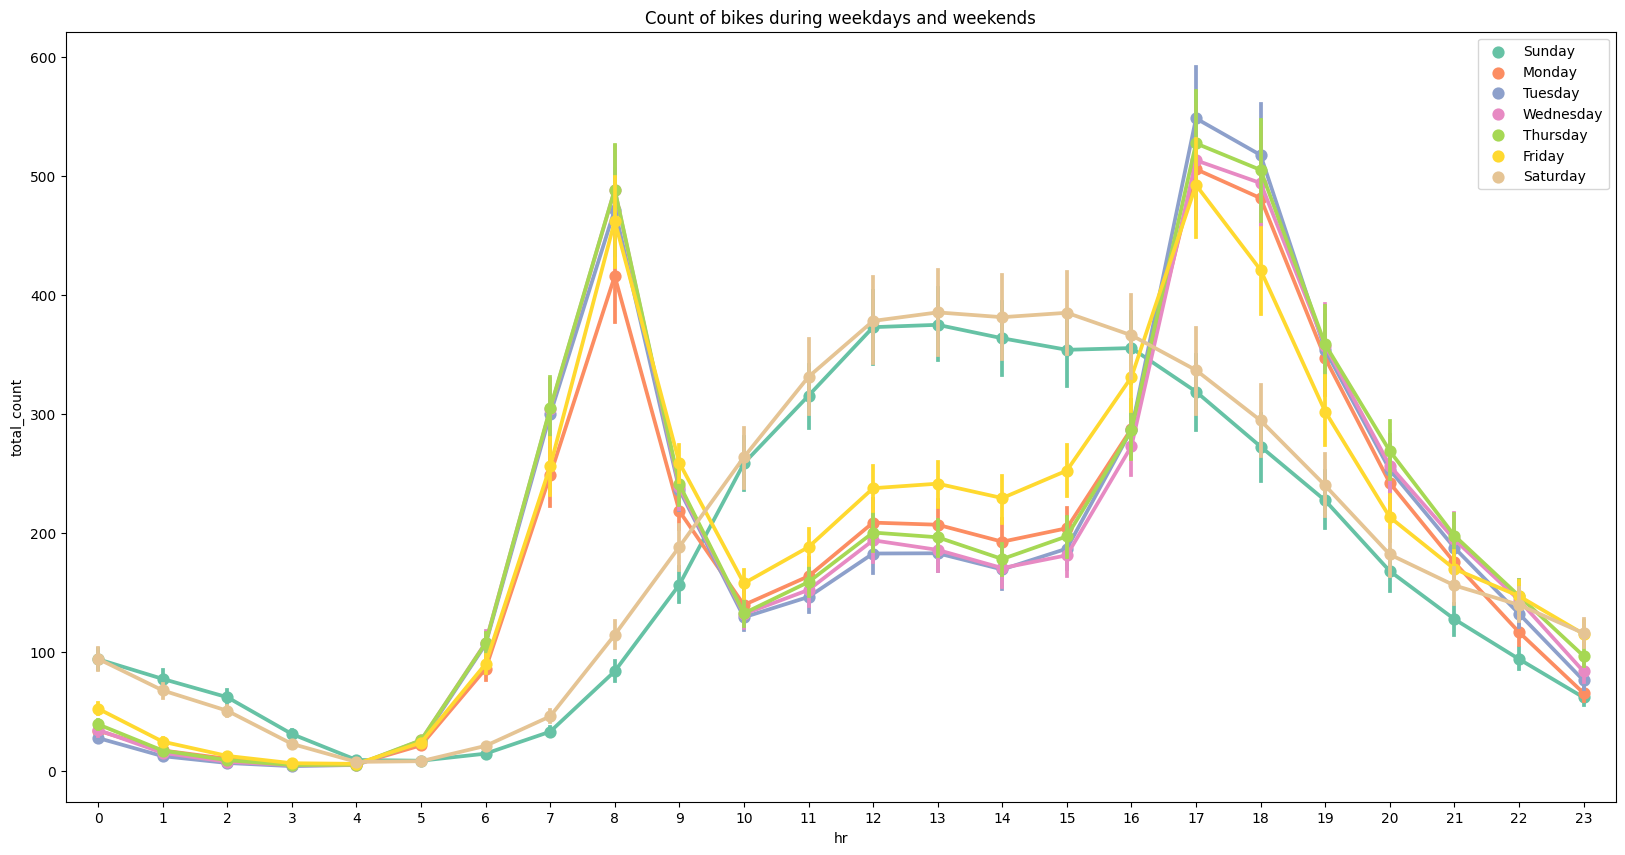

In [ ]:

fig, ax = plt.subplots(figsize=(20,10))
sns.pointplot(data=df_data_encoded, x='hr', y='total_count', hue='weekday', ax=ax, palette='Set2')
ax.set(title='Count of bikes during weekdays and weekends')


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

INSIGHTS:

1. Peak time is at around 7am and 5pm on Weekdays
2. Peak time for weekends is at afternoon between 12-01Pm

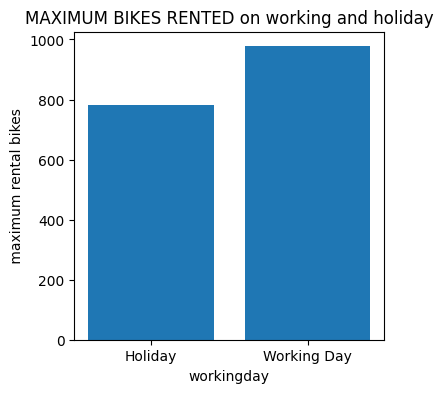

In [ ]:
plt.figure(figsize=(4,4))
plt.bar(df_data_encoded["workingday"],df_data_encoded["total_count"])
plt.ylabel(' maximum rental bikes ')
plt.xlabel('workingday')
plt.title("MAXIMUM BIKES RENTED on working and holiday")
plt.xticks([1,2],['Holiday', 'Working Day'])
plt.show()

INSIGHTS:


Max Bike Rentals are occured on Working Days

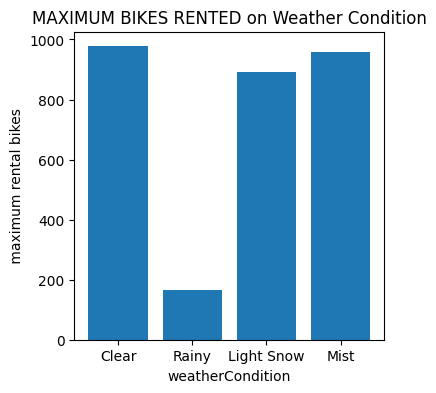

In [ ]:
plt.figure(figsize=(4,4))
plt.bar(df_data_encoded["weatherCondition"],df_data_encoded["total_count"])
plt.ylabel(' maximum rental bikes ')
plt.xlabel('weatherCondition')
plt.title("MAXIMUM BIKES RENTED on Weather Condition")
plt.xticks([1,2,3,4],['Clear', 'Rainy', 'Light Snow', 'Mist'])
plt.show()

1. Clear
2. Rainy
3. Light Snow
4. Mist

INSIGHTS:

It is observed that Bike Rentals are very high on Clear Weather onditions and very low on Rainy Conditions.

[619473.0, 2670313.0]


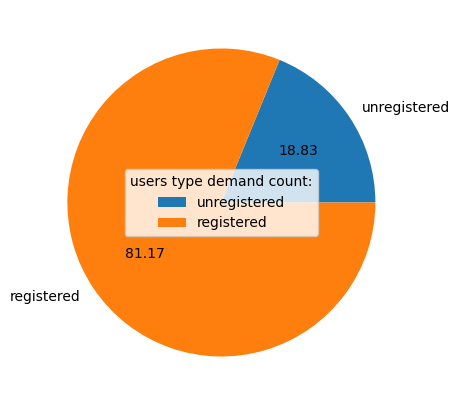

In [ ]:
plt.figure(figsize=(5,5))
u_t=df_data_encoded["unregistered"].sum()
r_t=df_data_encoded["registered"].sum()
l=[u_t,r_t]
print(l)
mylabels = ["unregistered", "registered"]
plt.pie(l,labels = mylabels,autopct ='%.2f')
plt.legend(title = "users type demand count:")
plt.show()

INSIGHTS :
The demand of registered users were high as they were 81.17%

So Management should give some schemes to unregistered users in order to convert imto registered users

<Axes: >

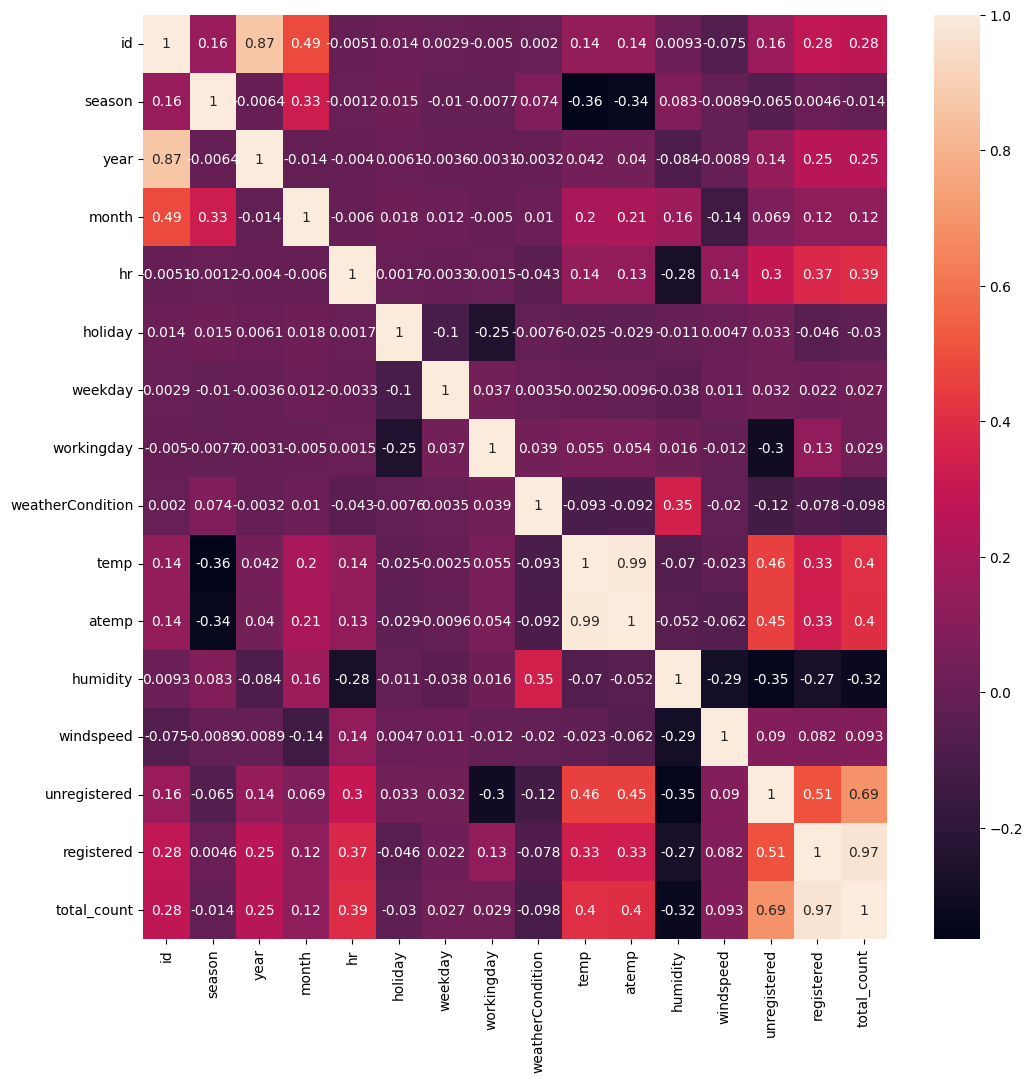

In [ ]:
plt.figure(figsize=(12,12))
a = df_data_encoded.corr()
sns.heatmap(a,annot = True)

INSIGHTS:

Features that are higjly Corelated to Total_count:

1. Registered Users are very Strongly Corelated with total_count - 0.97
2. Unregisterd also Positively strong corelared with total_count - 0.69
3. hr is positively corelated with total_count - 0.39
4. temp is positively corelated with total_count - 0.4
5. Hunidity is Negatively corelated with total_count - -0.32


Let us Hunt for Outliers:

In [ ]:
df_data_encoded

,id,datetime,season,year,month,hr,holiday,weekday,workingday,weatherCondition,temp,atemp,humidity,windspeed,unregistered,registered,total_count
0,1,2011-01-01,2,1,1,0,1,6,1,1,0.24,0.2879,0.81,0.0000,3.0,13.0,16
1,2,2011-01-01,2,1,1,1,1,6,1,1,0.22,0.2727,0.80,0.0000,8.0,32.0,40
3,4,2011-01-01,2,1,1,3,1,6,1,1,0.24,0.2879,0.75,0.0000,3.0,10.0,13
4,5,2011-01-01,2,1,1,4,1,6,1,1,0.24,0.2879,0.75,0.0000,0.0,1.0,1
5,6,2011-01-01,2,1,1,5,1,6,1,4,0.24,0.2576,0.75,0.0896,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17370,17371,2012-12-31,2,2,12,15,1,1,2,4,0.28,0.2879,0.45,0.1343,69.0,246.0,315
17373,17374,2012-12-31,2,2,12,18,1,1,2,4,0.26,0.2727,0.48,0.1343,10.0,112.0,122
17374,17375,2012-12-31,2,2,12,19,1,1,2,4,0.26,0.2576,0.60,0.1642,11.0,108.0,119
17375,17376,2012-12-31,2,2,12,20,1,1,2,4,0.26,0.2576,0.60,0.1642,8.0,81.0,89


In [ ]:
df_data_encoded.dtypes

id                           int64
datetime            datetime64[ns]
season                       int64
year                         int64
month                        int64
hr                           int64
holiday                      int64
weekday                      int64
workingday                   int64
weatherCondition             int64
temp                       float64
atemp                      float64
humidity                   float64
windspeed                  float64
unregistered               float64
registered                 float64
total_count                  int64
dtype: object

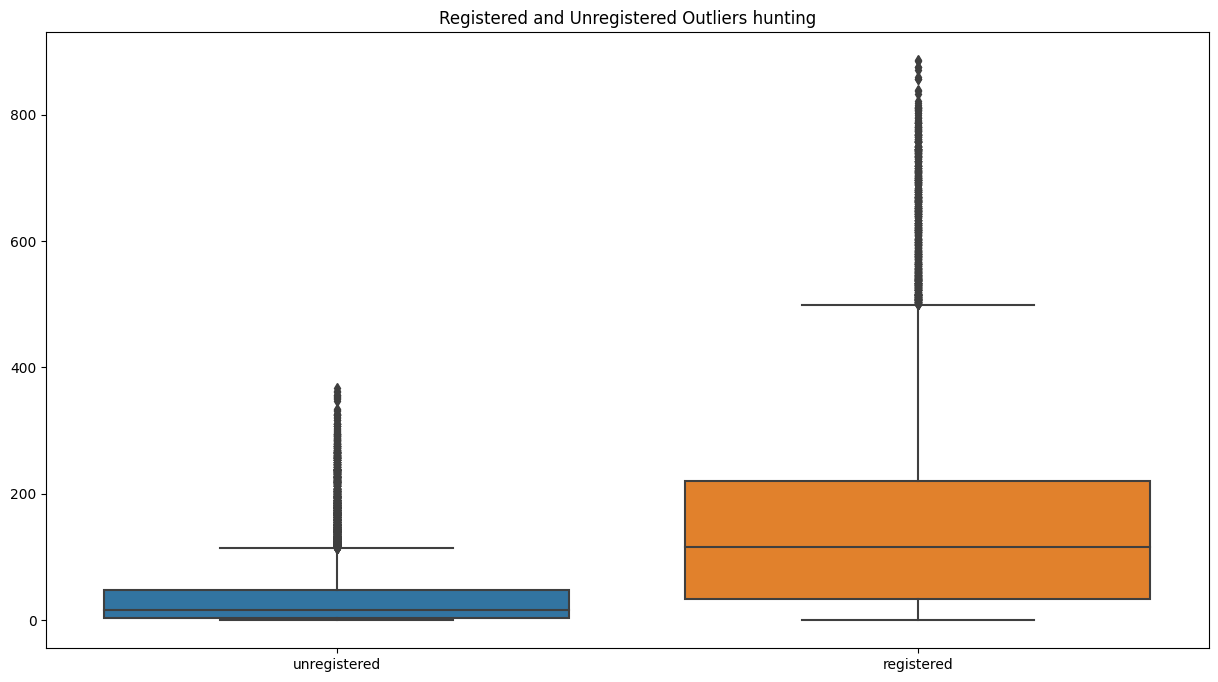

In [ ]:
fig,ax=plt.subplots(figsize=(15,8))
#Box plot for registered and unregistered users
sns.boxplot(data=df_data_encoded[['unregistered','registered']])
ax.set_title('Registered and Unregistered Outliers hunting')
plt.show()


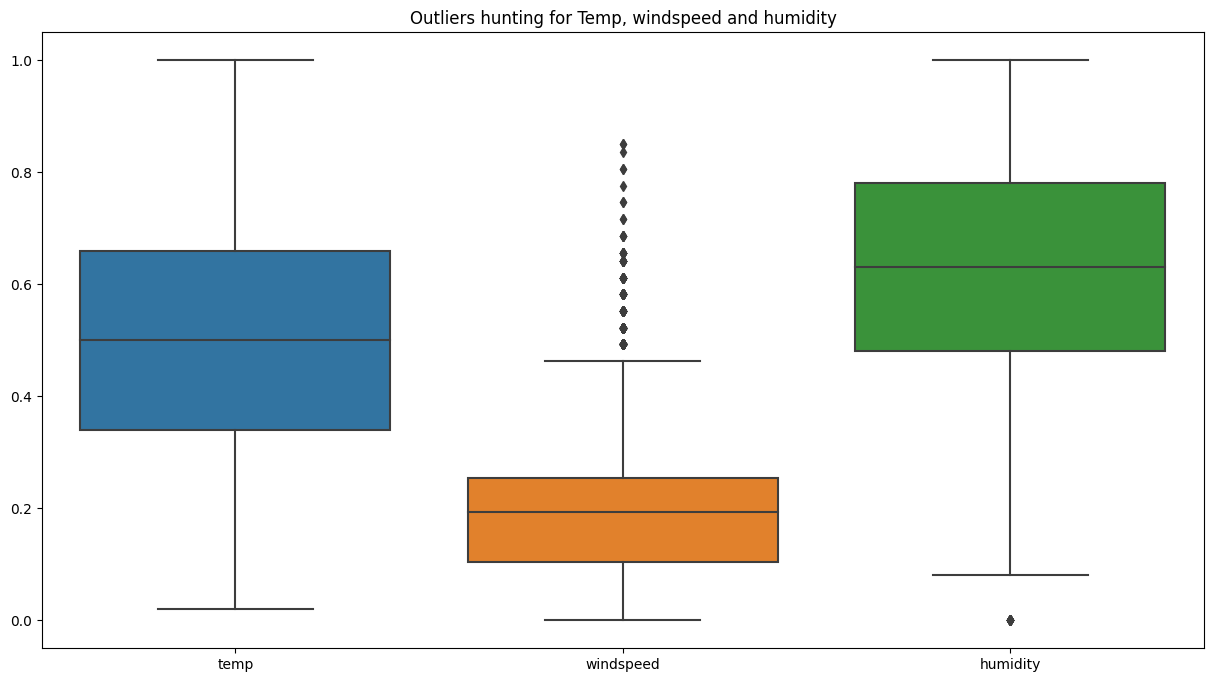

In [ ]:
fig,ax=plt.subplots(figsize=(15,8))
#Box plot for Temp, Windspeed and humidity
sns.boxplot(data=df_data_encoded[['temp','windspeed', 'humidity']])
ax.set_title('Outliers hunting for Temp, windspeed and humidity')
plt.show()


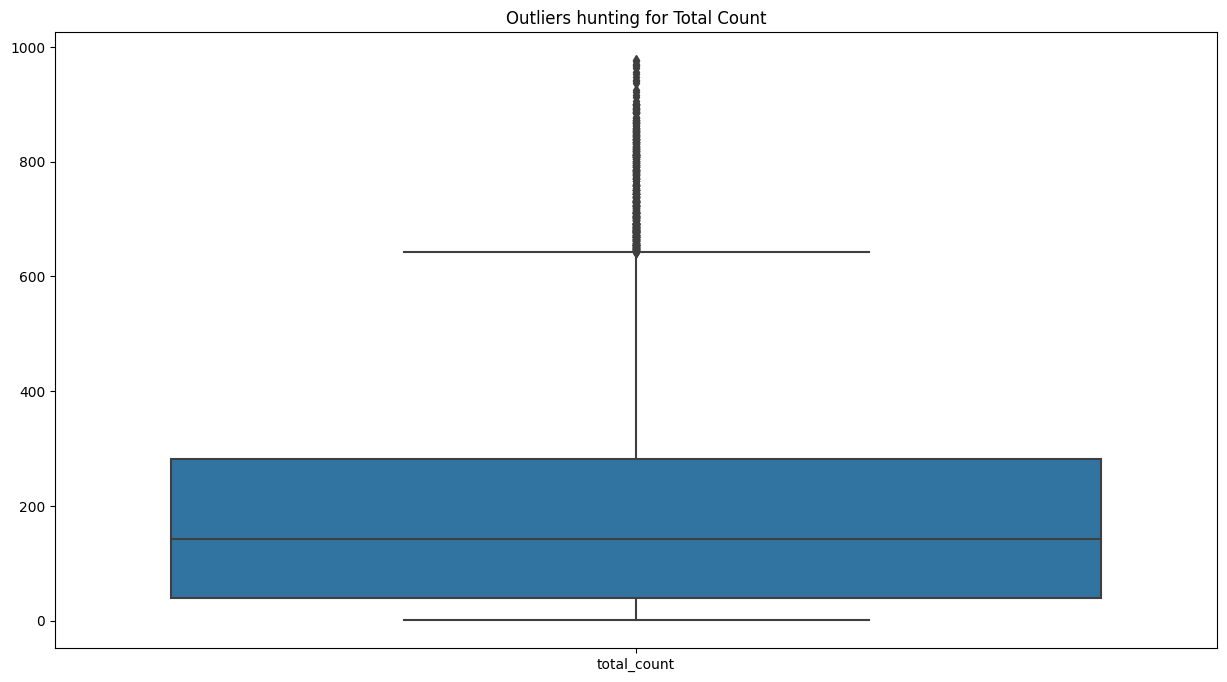

In [ ]:
fig,ax=plt.subplots(figsize=(15,8))
#Box plot for Total Count
sns.boxplot(data=df_data_encoded[['total_count']])
ax.set_title('Outliers hunting for Total Count')
plt.show()


INSIGHTS for Outliers:

1. Observed that there are few outliers for Total_count,windspeed, Registered and unregistered columns, we have to handle these columns and impute to main data set

2. No outliers were found for temp, so no actions needed

3. Very few/Negligble outliers were found for Humidity, which we can ignore.

In [ ]:
# Columns that are having Outliers:

col_outliers = ['total_count', 'humidity', 'windspeed', 'registered', 'unregistered']

In [ ]:
# function for plotting Box plot for columns having outliers

def boxplot_outliers(df):
  fig,ax=plt.subplots(figsize=(20,10))
  sns.boxplot(data=df[['total_count','windspeed', 'humidity', 'registered', 'unregistered']])
  ax.set_title('Outliers hunting')
  plt.show()

## **Handling Outliers:**

We have different methods to handle outliers:

1. Remove the outlier: If an outlier is due to an error in the data collection process, it may be appropriate to simply remove the outlier from the dataset. However, if the outlier is a legitimate data point, it may not be appropriate to simply remove it.

2. Winsorize the data: Winsorizing is a method that involves setting extreme values in the dataset to a specified percentile value. For example, you might set all data points above the 99th percentile to the value at the 99th percentile. This can help to reduce the impact of outliers without removing them entirely.

3. IQR:  IQR method, we first calculate the 25th and 75th percentiles (q1 and q3) and then calculate the interquartile range (iqr) by subtracting q1 from q3. We then define the lower and upper bounds using the formula lower_bound = q1 - (1.5 * iqr) and upper_bound = q3 + (1.5 * iqr). Finally, we replace the outliers with the corresponding bounds.

4. Capping: we first define a percentage (c) of values to be capped (in this case, 5%). We then calculate the lower and upper bounds by taking the cth and (1-c)th percentiles of the data. Finally, we replace the outliers with the corresponding bounds.

5. Transform the data: Transformation methods, such as log transformation or square root transformation, can be used to reduce the impact of outliers. These transformations can help to make the distribution of the data more normal, which can make it easier to apply statistical methods.

Method 1:  Since we have many outliers, removing those entries will lead to loss of valuable data. So Considering it as inefficient.

Method 2: Winsorize:Winsorizing is a method of handling outliers that involves replacing extreme values with the nearest non-outlier value. In other words, instead of deleting or transforming the outliers, the method modifies them to bring them closer to the bulk of the data.

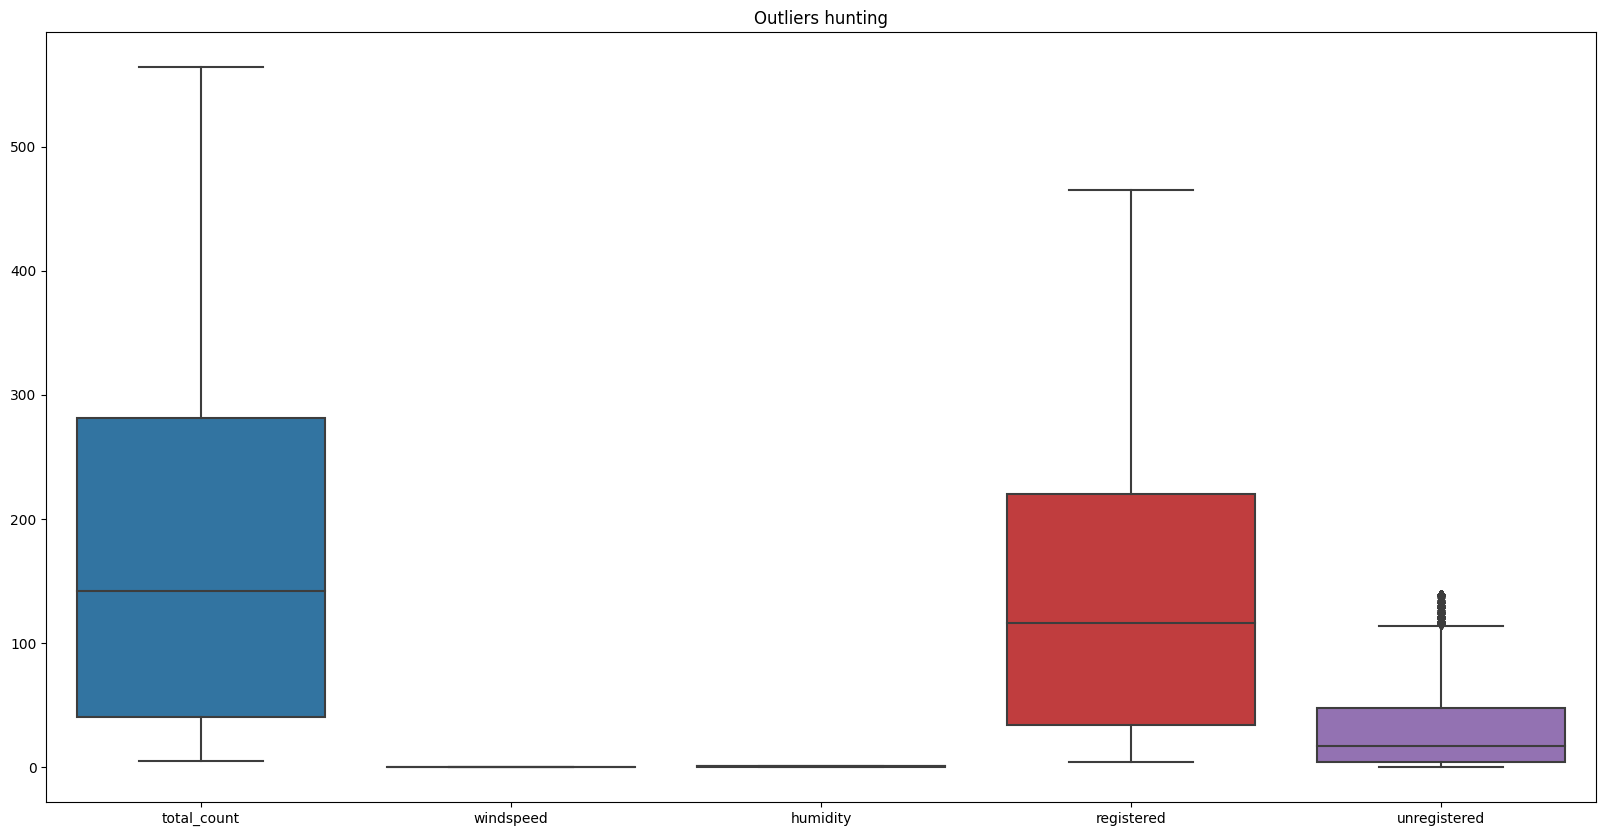

In [ ]:
# Method 2
from scipy.stats.mstats import winsorize


#copying the data
df_winsorize = df_data_encoded.copy()

for col in col_outliers:
    df_winsorize[col] = winsorize(df_winsorize[col], limits=[0.05, 0.05]) #standard limit value 5%

boxplot_outliers(df_winsorize)

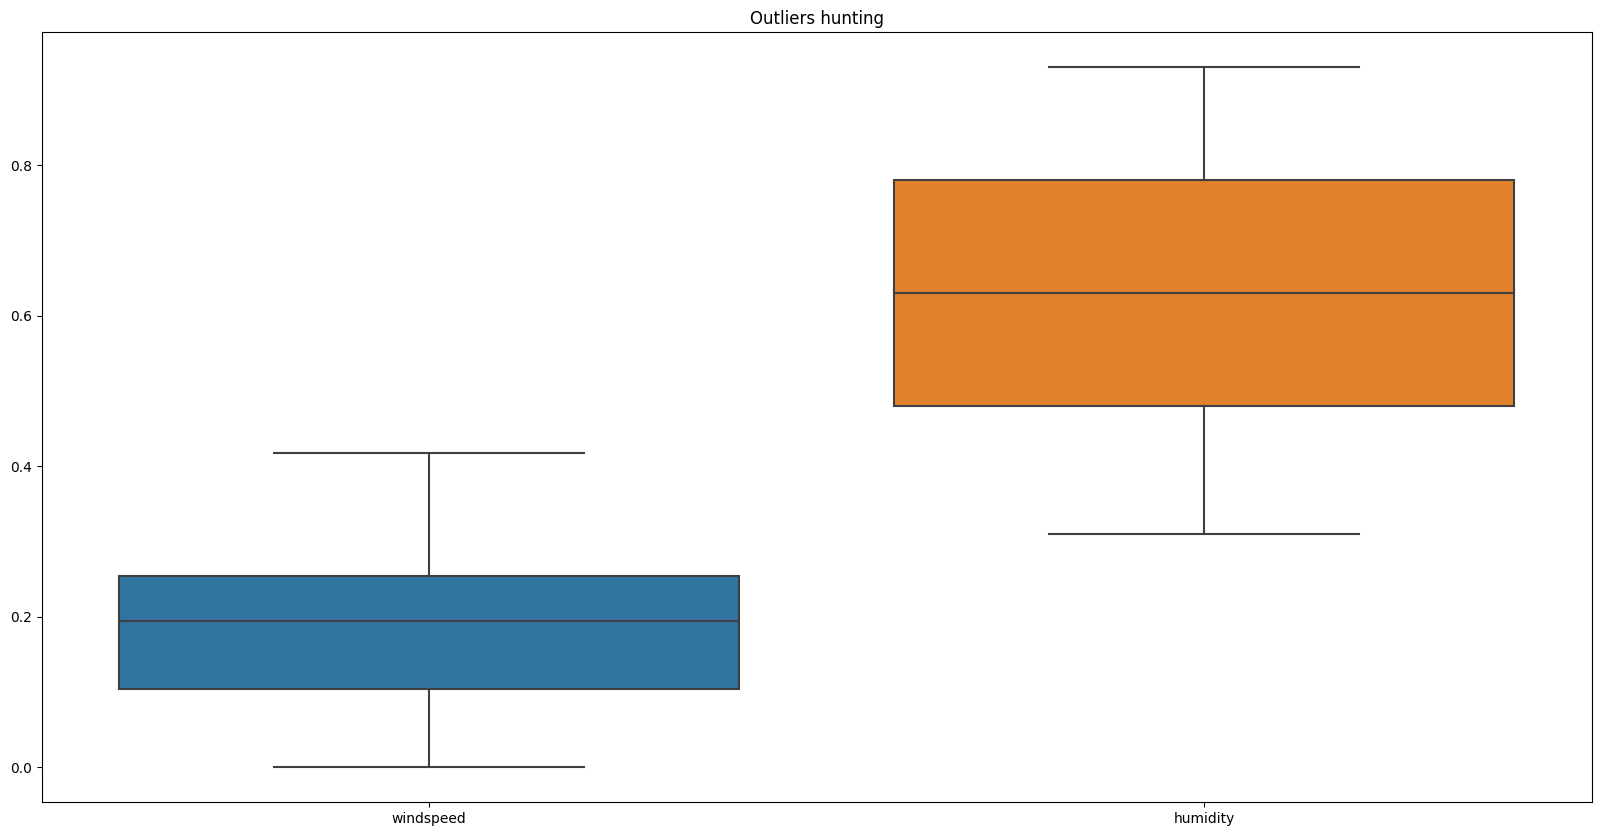

In [ ]:
fig,ax=plt.subplots(figsize=(20,10))
sns.boxplot(data=df_winsorize[['windspeed', 'humidity']])
ax.set_title('Outliers hunting')
plt.show()

In the method I suggested, the limits are dynamically calculated based on the interquartile range (IQR) of the data. The lower and upper limits are set to Q1 - 1.5IQR and Q3 + 1.5IQR, respectively, where Q1 and Q3 are the first and third quartiles of the data. 

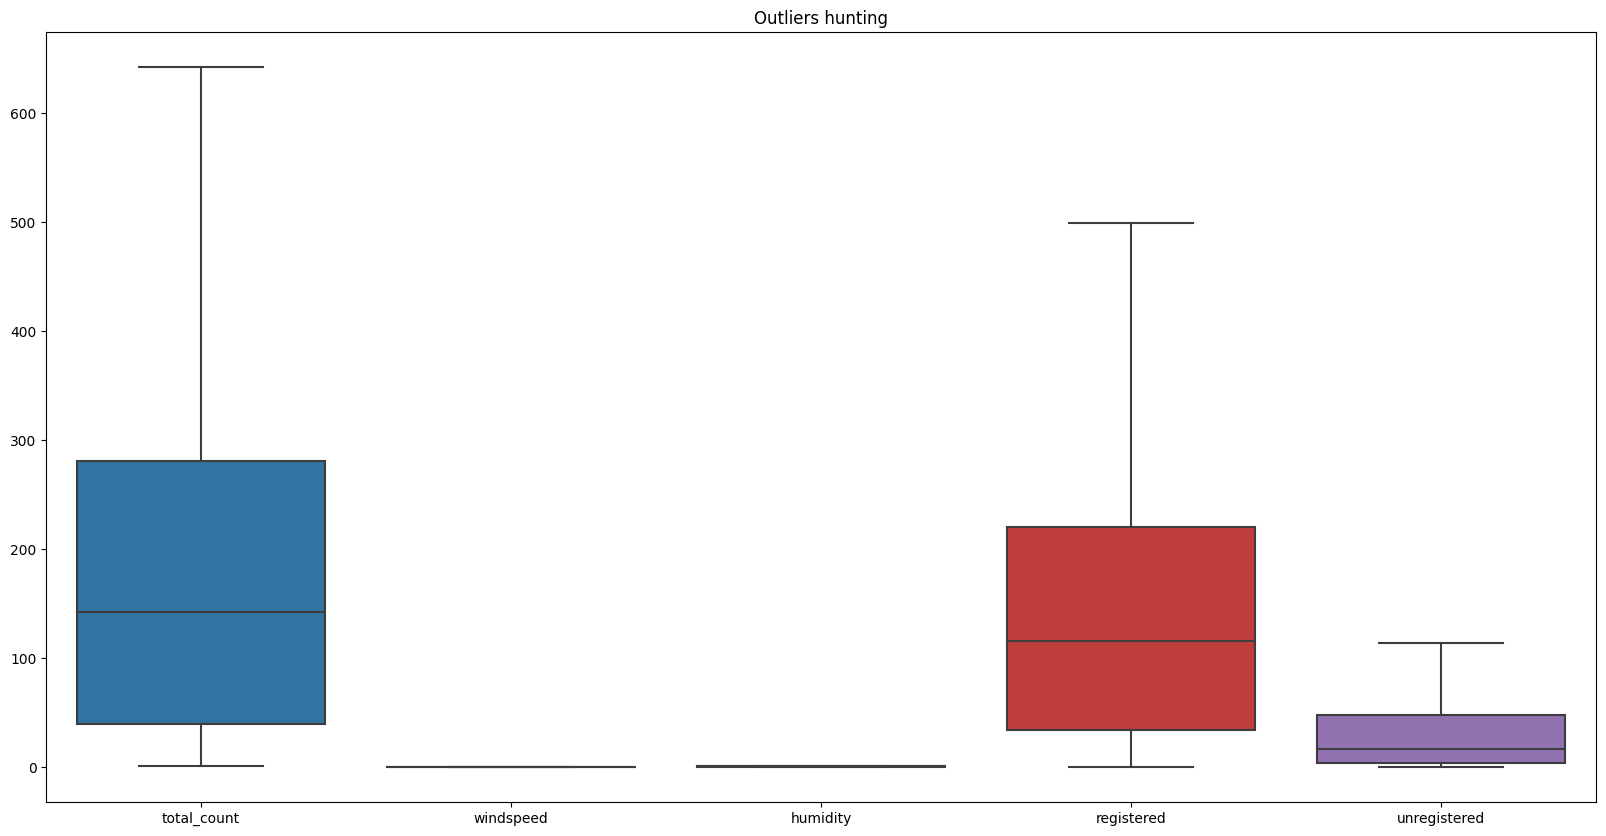

In [ ]:
# Method 2 winsorize with custom limits
from scipy.stats.mstats import winsorize


#copying the data
df_winsorize_cus = df_data_encoded.copy()

for col in col_outliers:
    q1 = df_winsorize_cus[col].quantile(0.25)
    q3 = df_winsorize_cus[col].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    df_winsorize_cus[col] = winsorize(df_winsorize_cus[col], limits=[(df_winsorize_cus[col] < lower_limit).sum() / len(df_winsorize_cus), (df_winsorize_cus[col] > upper_limit).sum() / len(df_winsorize_cus)])


boxplot_outliers(df_winsorize_cus)

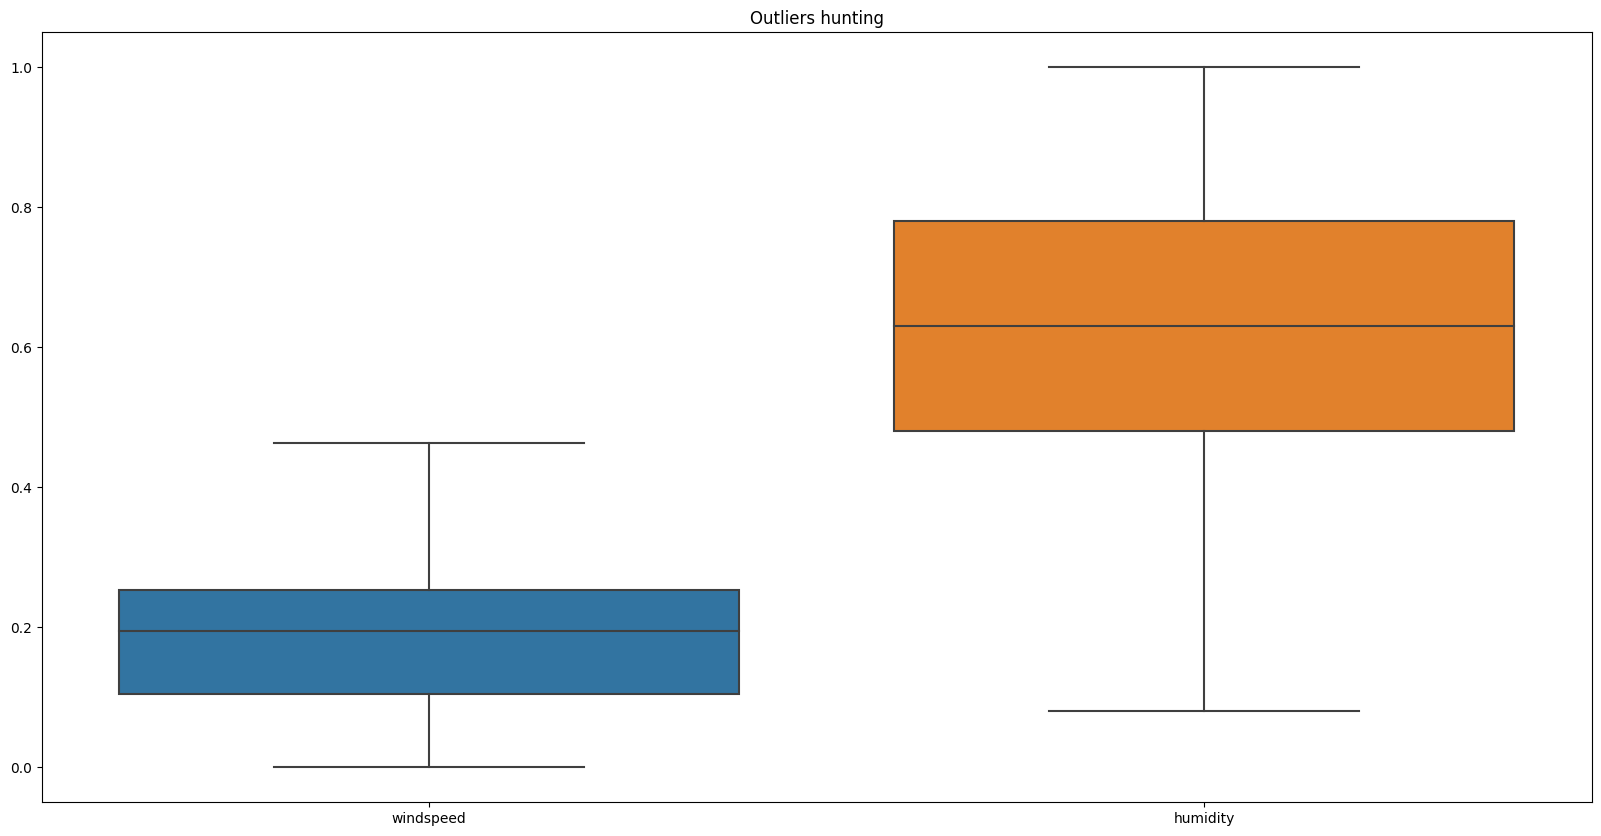

In [ ]:
fig,ax=plt.subplots(figsize=(20,10))
sns.boxplot(data=df_winsorize_cus[['windspeed', 'humidity']])
ax.set_title('Outliers hunting')
plt.show()

Method 3: transformation, although we have multiple transformations like sqrt,log etc..

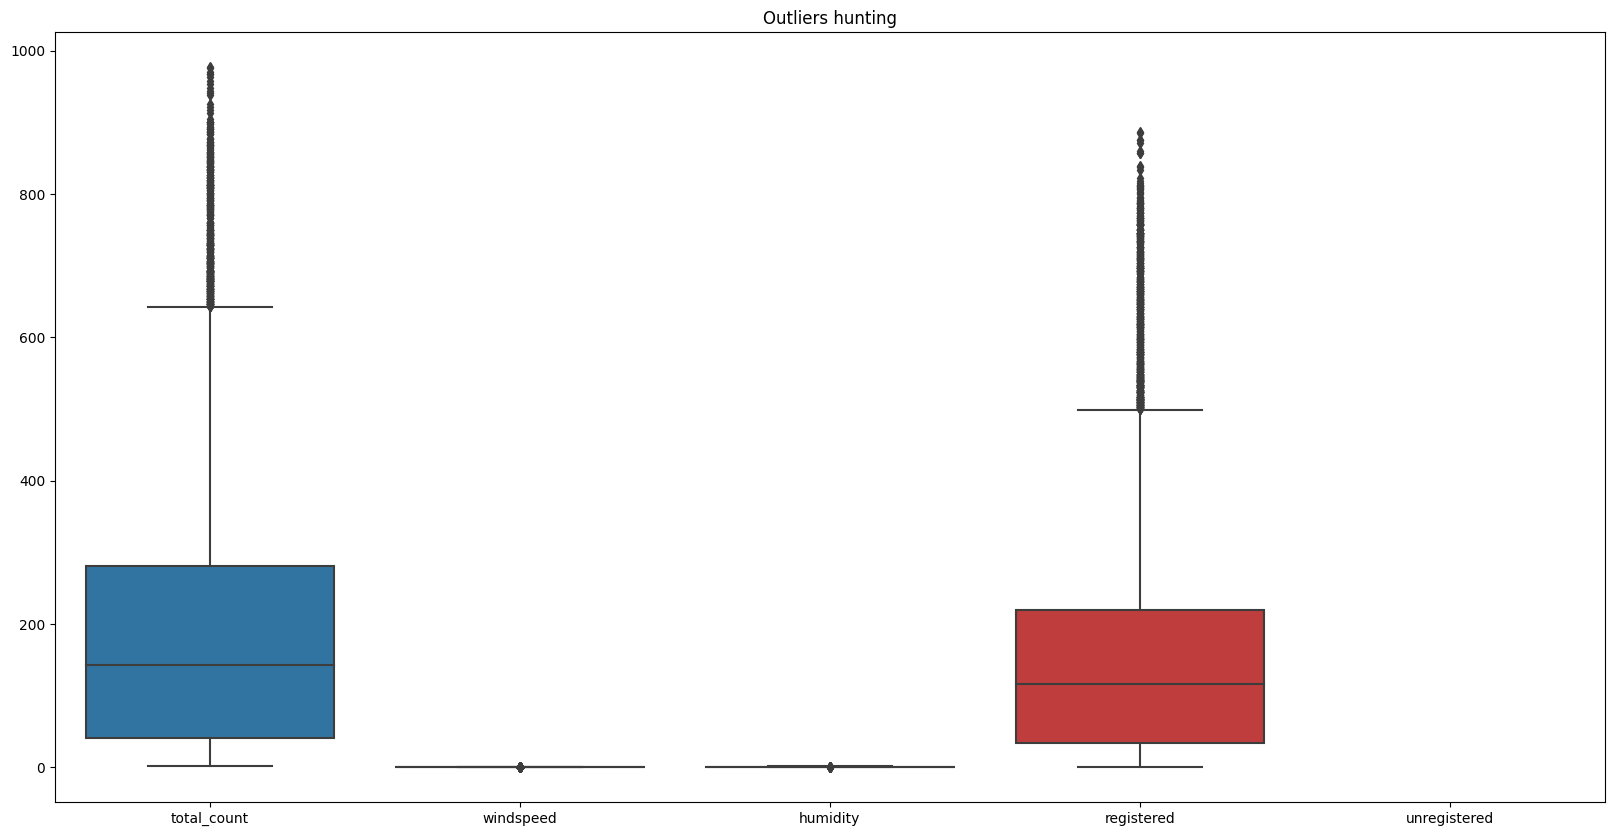

In [ ]:
# Method 3: let us perform SQRT and LOG

df_log = df_data_encoded.copy()
df_sqrt = df_data_encoded.copy()

for cols in col_outliers:
  df_log[col] = np.log(df_log[col])

boxplot_outliers(df_log)

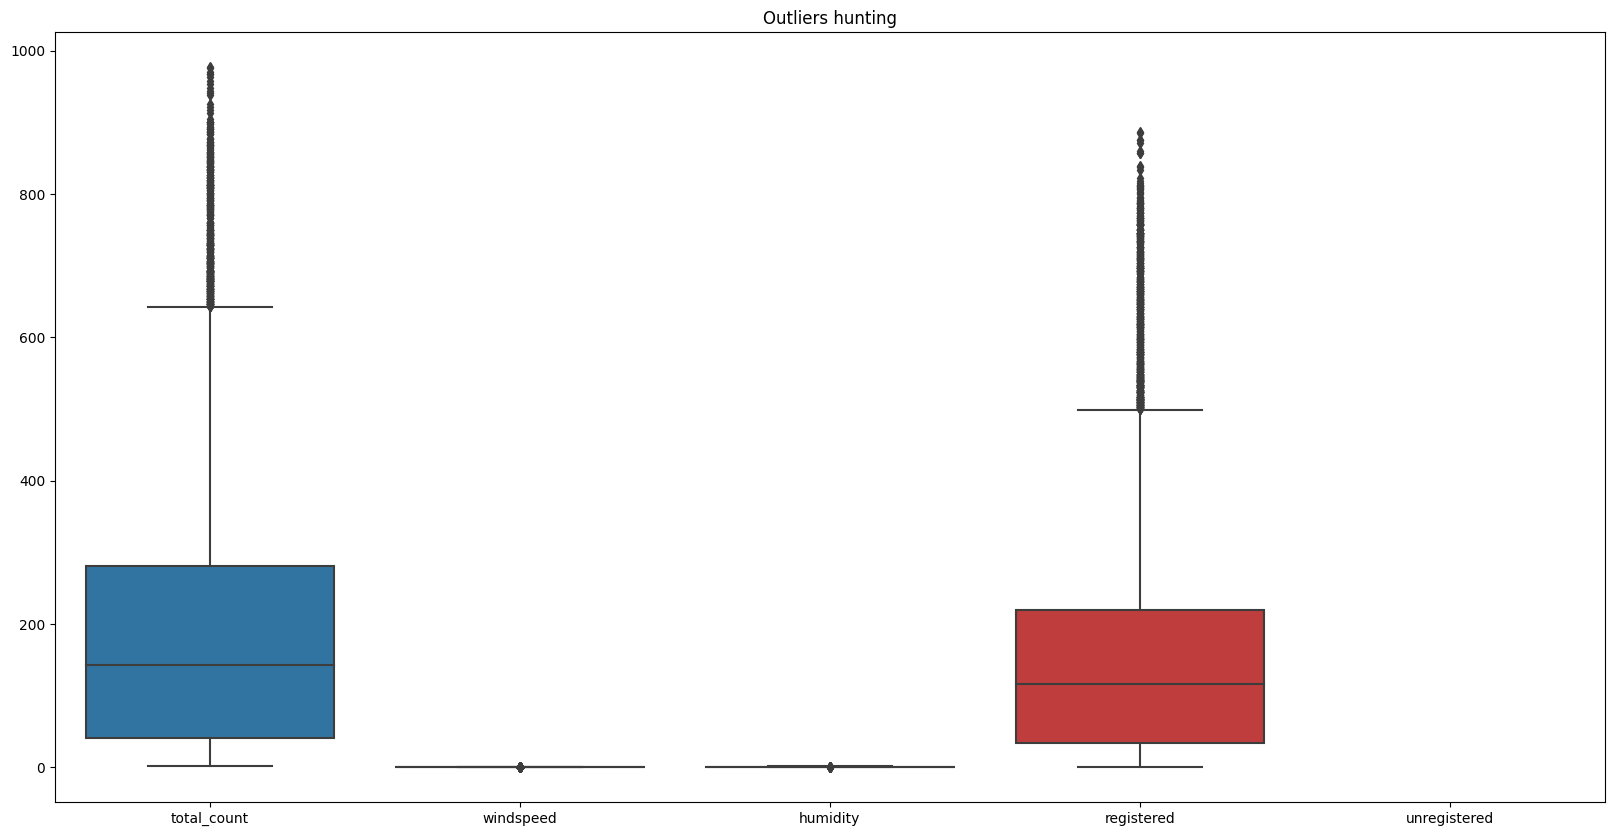

In [ ]:
for cols in col_outliers:
  df_sqrt[col] = np.sqrt(df_log[col])

boxplot_outliers(df_sqrt)

Method 4: Capping: we first define a percentage (c) of values to be capped (in this case, 5%). We then calculate the lower and upper bounds by taking the cth and (1-c)th percentiles of the data. Finally, we replace the outliers with the corresponding bounds.

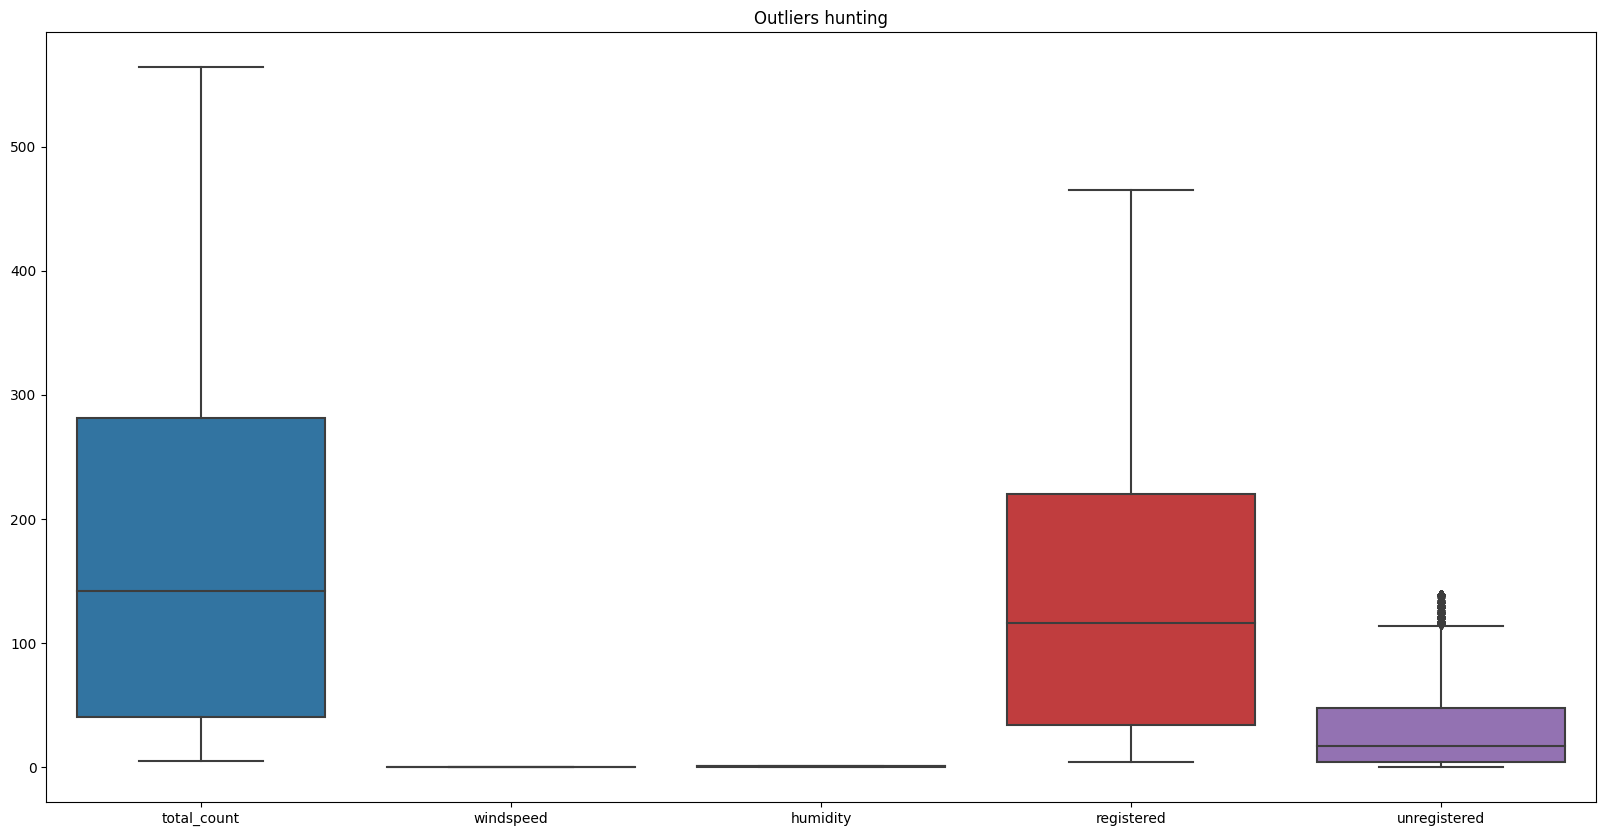

In [ ]:
#copying data
df_capping = df_data_encoded.copy()


for col in col_outliers:
    c = 0.05 
    q1 = df_capping[col].quantile(c)
    q2 = df_capping[col].quantile(1-c)
    df_capping[col] = np.where(df_capping[col] < q1, q1, df_capping[col])
    df_capping[col] = np.where(df_capping[col] > q2, q2, df_capping[col])
boxplot_outliers(df_capping)

Let us change capping value to 0.1 and check for outliers

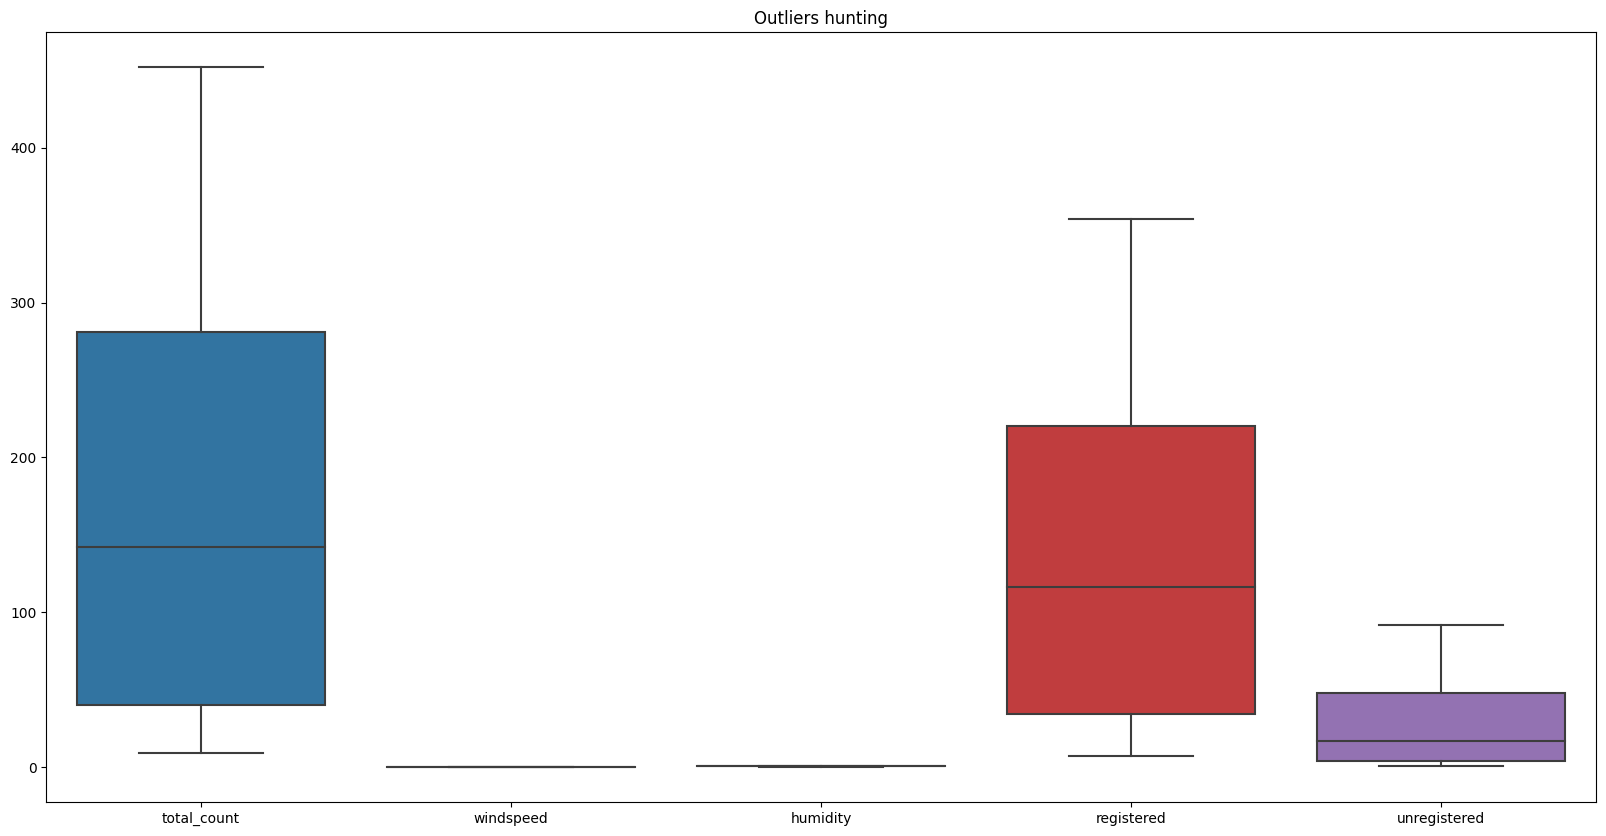

In [ ]:
#copying data
df_capping_1 = df_data_encoded.copy()


for col in col_outliers:
    c = 0.1
    q1 = df_capping_1[col].quantile(c)
    q2 = df_capping_1[col].quantile(1-c)
    df_capping_1[col] = np.where(df_capping_1[col] < q1, q1, df_capping_1[col])
    df_capping_1[col] = np.where(df_capping_1[col] > q2, q2, df_capping_1[col])
boxplot_outliers(df_capping_1)

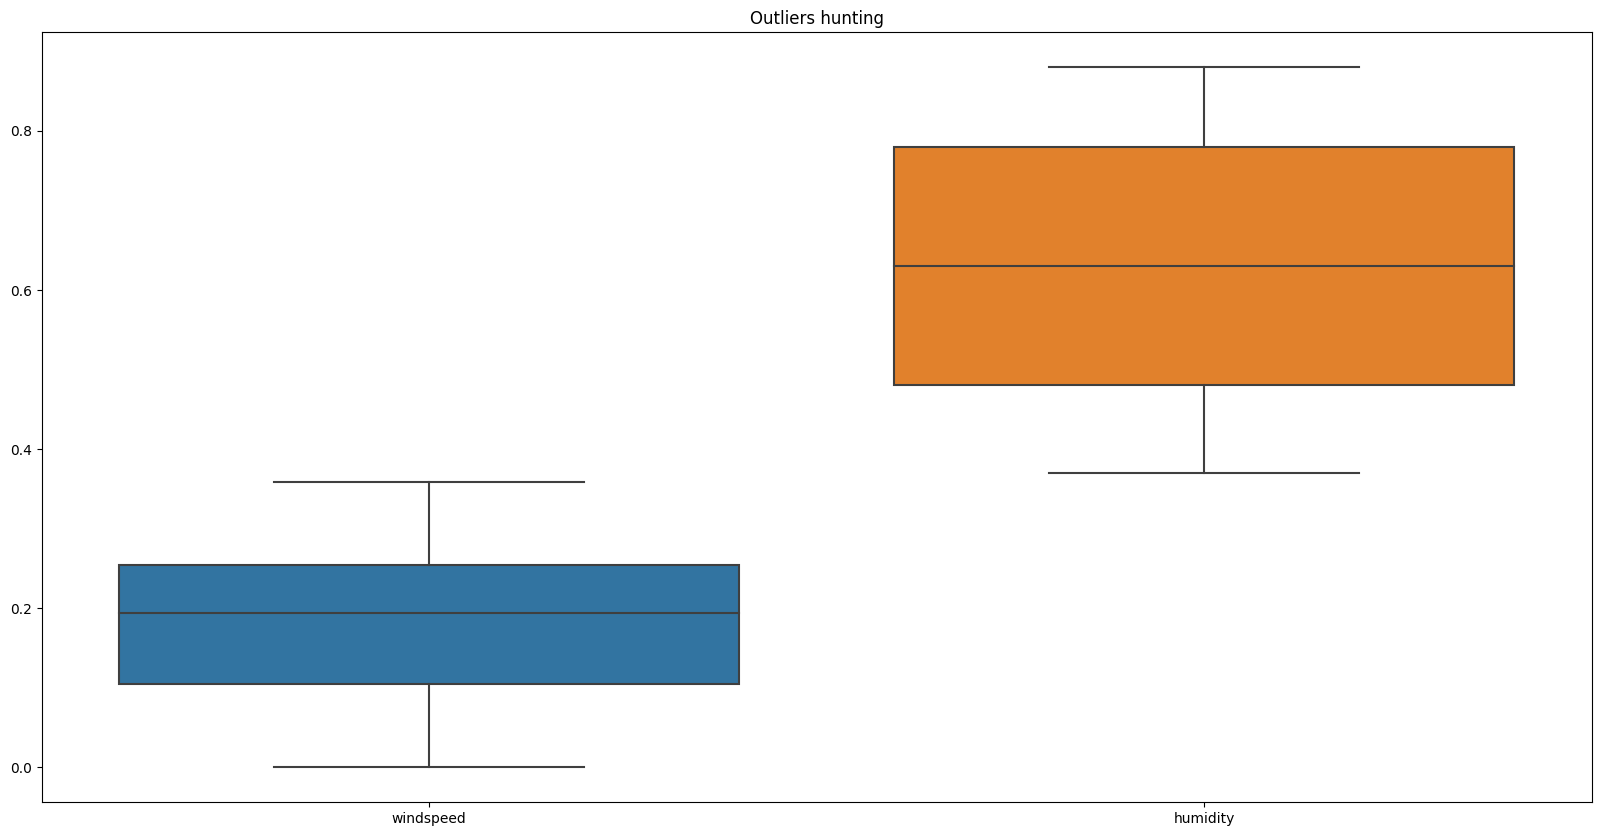

In [ ]:
fig,ax=plt.subplots(figsize=(20,10))
sns.boxplot(data=df_capping_1[['windspeed', 'humidity']])
ax.set_title('Outliers hunting')
plt.show()

Method 5: IQR 

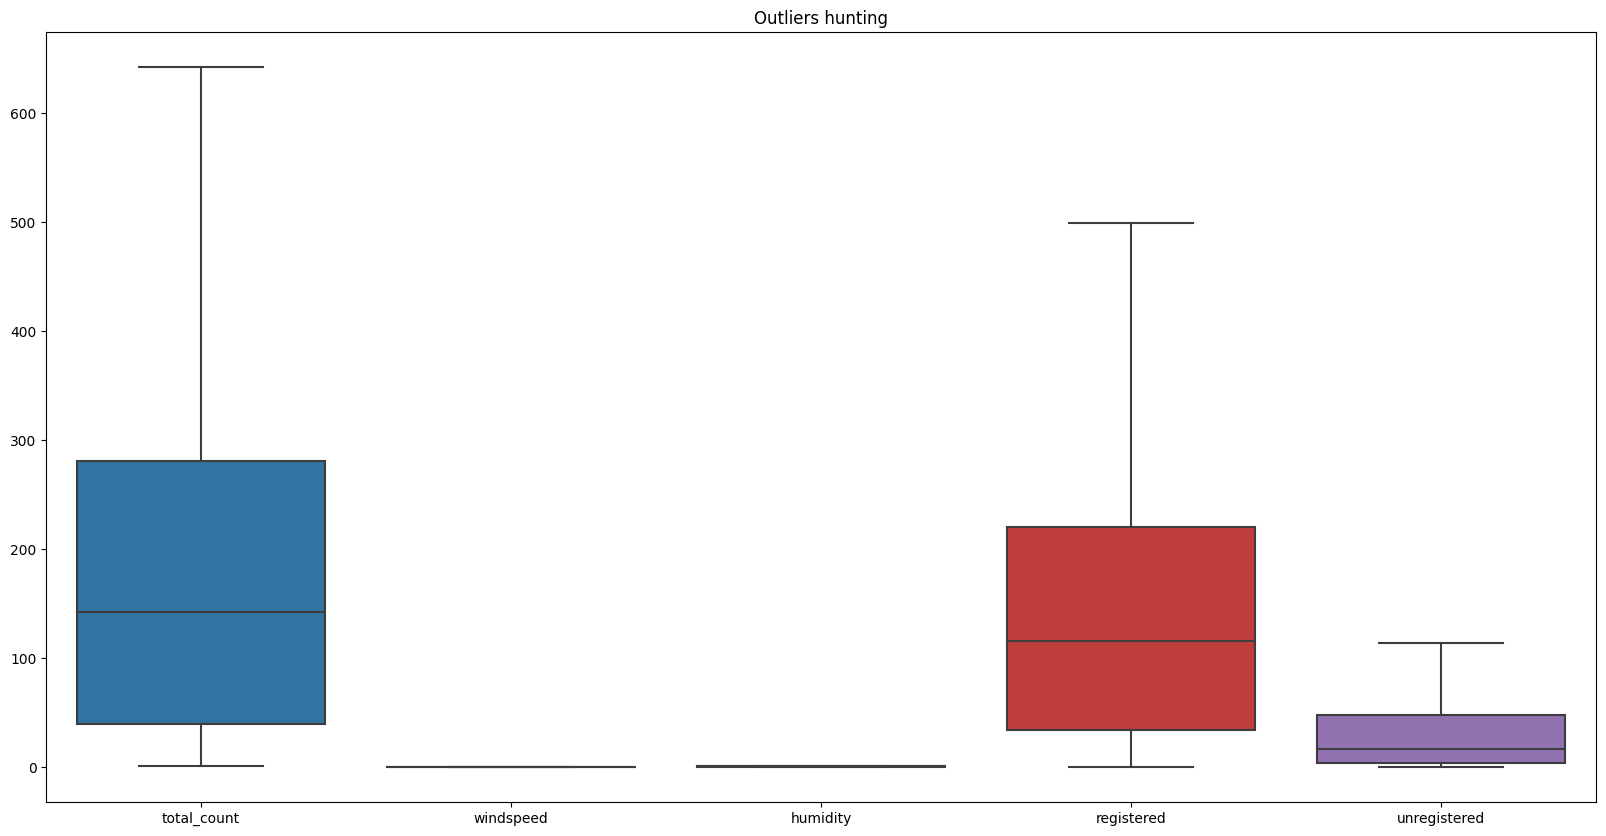

In [ ]:
df_IQR = df_data_encoded.copy()

for col in col_outliers:
    q1 = np.percentile(df_IQR[col], 25)
    q3 = np.percentile(df_IQR[col], 75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    df_IQR[col] = np.where(df_IQR[col] < lower_bound, lower_bound, df_IQR[col])
    df_IQR[col] = np.where(df_IQR[col] > upper_bound, upper_bound, df_IQR[col])

boxplot_outliers(df_IQR)


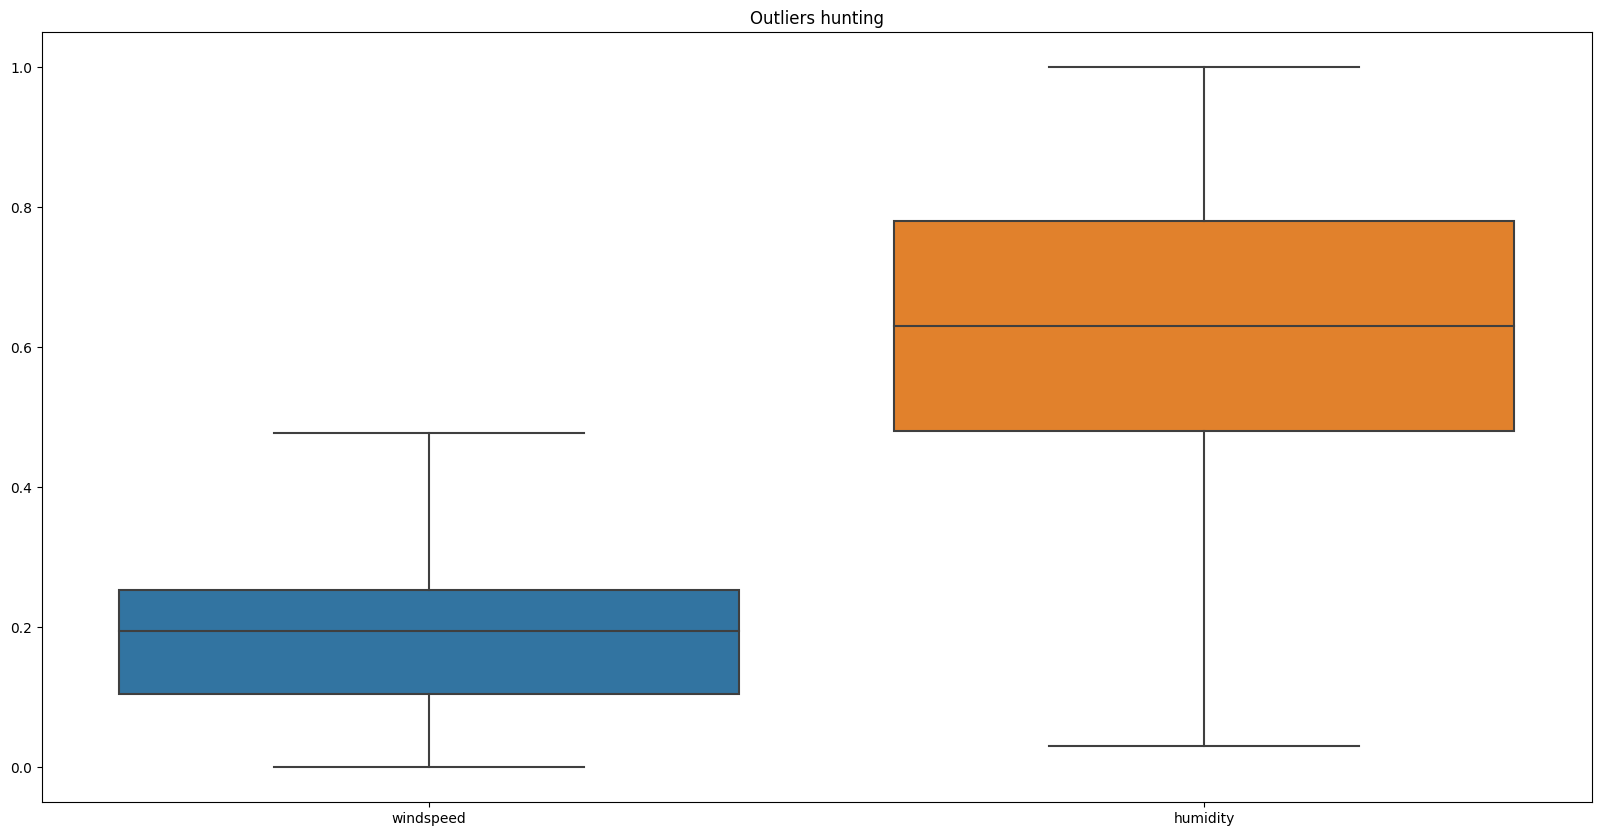

In [ ]:
fig,ax=plt.subplots(figsize=(20,10))
sns.boxplot(data=df_IQR[['windspeed', 'humidity']])
ax.set_title('Outliers hunting')
plt.show()

If we observe that for the Methods IQR, capping with 0.1 and Winsorizing, our datset is completely outlier free. So inorder to determine the best method, let us implement sample random regressor and find the efficiency for both data sets.

In [ ]:
def random_regressor(df, target_col):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df.drop(target_col, axis=1), df[target_col], test_size=0.25, random_state=42)
    
    # Fit a random forest regressor model
    model = RandomForestRegressor(n_estimators=10, random_state=0)
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate R-squared to evaluate model performance
    r2 = r2_score(y_test, y_pred)
    
    return r2


In [ ]:
df_IQR.dtypes

id                           int64
datetime            datetime64[ns]
season                       int64
year                         int64
month                        int64
hr                           int64
holiday                      int64
weekday                      int64
workingday                   int64
weatherCondition             int64
temp                       float64
atemp                      float64
humidity                   float64
windspeed                  float64
unregistered               float64
registered                 float64
total_count                float64
dtype: object

In [ ]:
target_col = 'total_count'
cols = ['season','year','month','hr','holiday','weekday','workingday','weatherCondition','temp','humidity','registered', 'unregistered', 'total_count','windspeed']


# R2 score for IQR dataset
r2 = random_regressor(df_IQR[cols], target_col)
print(f"R-squared score for IQR dataset: {r2}")

# R2 score for capping dataset
r2 = random_regressor(df_capping_1[cols], target_col)
print(f"R-squared score for capping with 0.1 dataset: {r2}")

# R2 score for winsorize dataset
r2 = random_regressor(df_winsorize_cus[cols], target_col)
print(f"R-squared score for winsorize dataset: {r2}")



R-squared score for IQR dataset: 0.9966736587694858
R-squared score for capping with 0.1 dataset: 0.9959245910610649
R-squared score for winsorize dataset: 0.9965980408843158


In [ ]:
# Based on the above observations, R2 is similar to all methods we performed. Considering IQR for its interpretaeasy bility and feasbility of usage


df_data_cleaned = df_IQR.copy()

In [ ]:
df_data_cleaned

,id,datetime,season,year,month,hr,holiday,weekday,workingday,weatherCondition,temp,atemp,humidity,windspeed,unregistered,registered,total_count
0,1,2011-01-01,2,1,1,0,1,6,1,1,0.24,0.2879,0.81,0.0000,3.0,13.0,16.0
1,2,2011-01-01,2,1,1,1,1,6,1,1,0.22,0.2727,0.80,0.0000,8.0,32.0,40.0
3,4,2011-01-01,2,1,1,3,1,6,1,1,0.24,0.2879,0.75,0.0000,3.0,10.0,13.0
4,5,2011-01-01,2,1,1,4,1,6,1,1,0.24,0.2879,0.75,0.0000,0.0,1.0,1.0
5,6,2011-01-01,2,1,1,5,1,6,1,4,0.24,0.2576,0.75,0.0896,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17370,17371,2012-12-31,2,2,12,15,1,1,2,4,0.28,0.2879,0.45,0.1343,69.0,246.0,315.0
17373,17374,2012-12-31,2,2,12,18,1,1,2,4,0.26,0.2727,0.48,0.1343,10.0,112.0,122.0
17374,17375,2012-12-31,2,2,12,19,1,1,2,4,0.26,0.2576,0.60,0.1642,11.0,108.0,119.0
17375,17376,2012-12-31,2,2,12,20,1,1,2,4,0.26,0.2576,0.60,0.1642,8.0,81.0,89.0


In [ ]:
# Extracting date from the datetime column and eleiminating datetime col as we got month and year info already

df_data_cleaned['date'] = pd.to_datetime(df_data_cleaned['datetime']).dt.day

df_data_cleaned

,id,datetime,season,year,month,hr,holiday,weekday,workingday,weatherCondition,temp,atemp,humidity,windspeed,unregistered,registered,total_count,date
0,1,2011-01-01,2,1,1,0,1,6,1,1,0.24,0.2879,0.81,0.0000,3.0,13.0,16.0,1
1,2,2011-01-01,2,1,1,1,1,6,1,1,0.22,0.2727,0.80,0.0000,8.0,32.0,40.0,1
3,4,2011-01-01,2,1,1,3,1,6,1,1,0.24,0.2879,0.75,0.0000,3.0,10.0,13.0,1
4,5,2011-01-01,2,1,1,4,1,6,1,1,0.24,0.2879,0.75,0.0000,0.0,1.0,1.0,1
5,6,2011-01-01,2,1,1,5,1,6,1,4,0.24,0.2576,0.75,0.0896,0.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17370,17371,2012-12-31,2,2,12,15,1,1,2,4,0.28,0.2879,0.45,0.1343,69.0,246.0,315.0,31
17373,17374,2012-12-31,2,2,12,18,1,1,2,4,0.26,0.2727,0.48,0.1343,10.0,112.0,122.0,31
17374,17375,2012-12-31,2,2,12,19,1,1,2,4,0.26,0.2576,0.60,0.1642,11.0,108.0,119.0,31
17375,17376,2012-12-31,2,2,12,20,1,1,2,4,0.26,0.2576,0.60,0.1642,8.0,81.0,89.0,31


<Axes: >

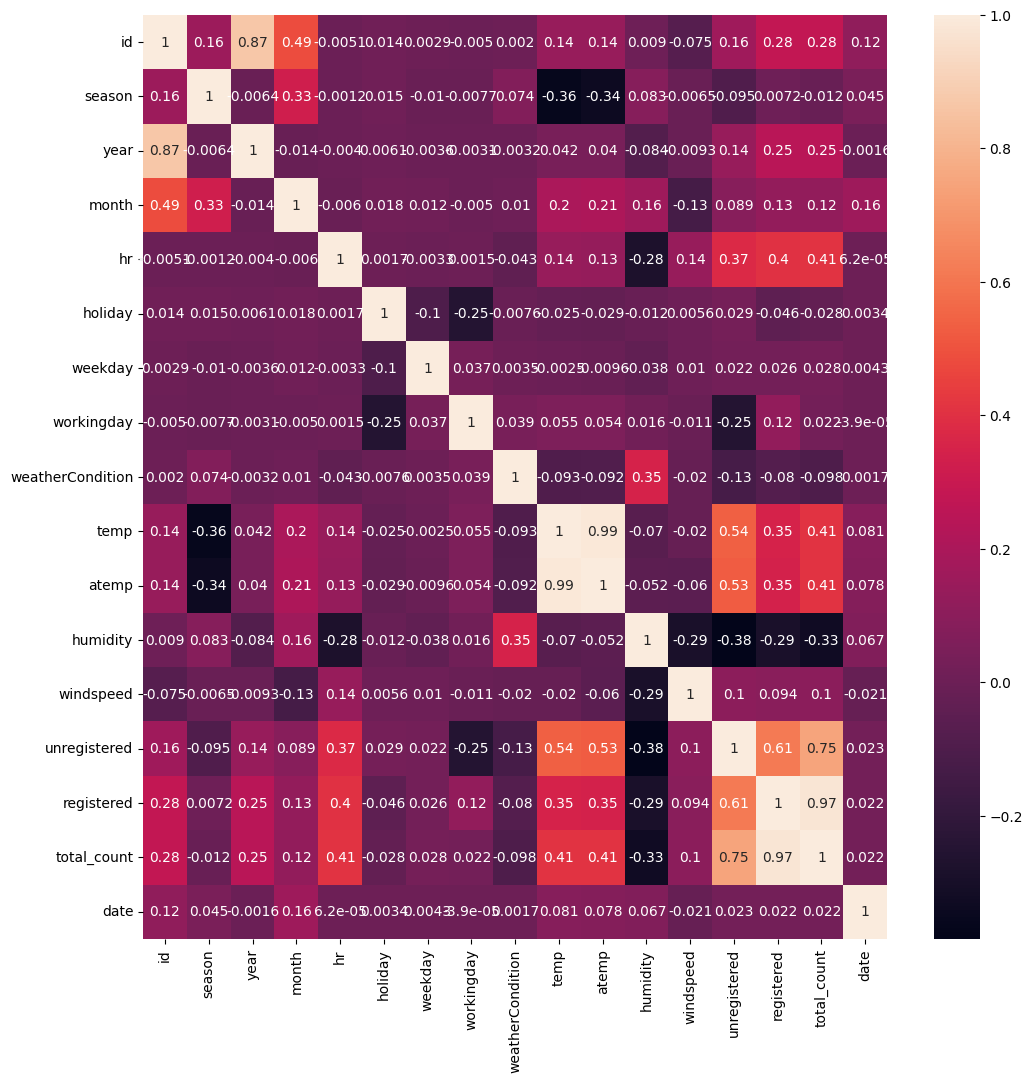

In [ ]:
plt.figure(figsize=(12,12))
a = df_data_cleaned.corr()
sns.heatmap(a,annot = True)

In [ ]:
df_data_cleaned.head()

,id,datetime,season,year,month,hr,holiday,weekday,workingday,weatherCondition,temp,atemp,humidity,windspeed,unregistered,registered,total_count,date
0,1,2011-01-01,2,1,1,0,1,6,1,1,0.24,0.2879,0.81,0.0000,3.0,13.0,16.0,1
1,2,2011-01-01,2,1,1,1,1,6,1,1,0.22,0.2727,0.80,0.0000,8.0,32.0,40.0,1
3,4,2011-01-01,2,1,1,3,1,6,1,1,0.24,0.2879,0.75,0.0000,3.0,10.0,13.0,1
4,5,2011-01-01,2,1,1,4,1,6,1,1,0.24,0.2879,0.75,0.0000,0.0,1.0,1.0,1
5,6,2011-01-01,2,1,1,5,1,6,1,4,0.24,0.2576,0.75,0.0896,0.0,1.0,1.0,1


FEATURE ENGINEERING:

In [ ]:
# Since ID wont plays any role in model performance, removing id from the dataset.
# As we have day,month and year factors in we can remove datetime column from dataset.

df_data_cleaned.drop(['id', 'datetime'], axis = 1, inplace=True)


In [ ]:
df_data_cleaned

,season,year,month,hr,holiday,weekday,workingday,weatherCondition,temp,atemp,humidity,windspeed,unregistered,registered,total_count,date
0,2,1,1,0,1,6,1,1,0.24,0.2879,0.81,0.0000,3.0,13.0,16.0,1
1,2,1,1,1,1,6,1,1,0.22,0.2727,0.80,0.0000,8.0,32.0,40.0,1
3,2,1,1,3,1,6,1,1,0.24,0.2879,0.75,0.0000,3.0,10.0,13.0,1
4,2,1,1,4,1,6,1,1,0.24,0.2879,0.75,0.0000,0.0,1.0,1.0,1
5,2,1,1,5,1,6,1,4,0.24,0.2576,0.75,0.0896,0.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17370,2,2,12,15,1,1,2,4,0.28,0.2879,0.45,0.1343,69.0,246.0,315.0,31
17373,2,2,12,18,1,1,2,4,0.26,0.2727,0.48,0.1343,10.0,112.0,122.0,31
17374,2,2,12,19,1,1,2,4,0.26,0.2576,0.60,0.1642,11.0,108.0,119.0,31
17375,2,2,12,20,1,1,2,4,0.26,0.2576,0.60,0.1642,8.0,81.0,89.0,31


In [ ]:
# As a part for performing Feature Engineering, We first check for valuable features in dataset. So that we can build model on the most important features.
# We have different methods to perform feature selection. 
# 1. Mutual Information (MI)
# 2. Recurrsive Feature Elimination (RFE)
# 3. L1 Regularization 
# 4. VIF
# 5. Tree Based
# Let us perform each method and choose best method by using simple RandomRegressor

Method 1 : Mutual Information (MI)
It can be used as a feature selection method by measuring the mutual information between each feature and the target variable and selecting the top-k features with the highest mutual information scores. Scikit-learn provides a mutual_info_regression function to compute mutual information for regression problems.



In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# copy a set from df_data_cleaned

df_data_MI = df_data_cleaned.copy()

# Separate the features and target variable
X = df_data_MI.drop('total_count', axis=1)
y = df_data_MI['total_count']
target_col = 'total_count'

selector = SelectKBest(mutual_info_regression)
selector.fit_transform(X, y)
# Get the indices of the selected features
selected_indices = selector.get_support(indices=True)
# Get the names of the selected features
selected_features = X.columns[selected_indices]
data_MI = pd.concat([X[selected_features],y], axis = 1)

print(selected_features)  

Index(['season', 'year', 'month', 'hr', 'temp', 'atemp', 'humidity',
       'unregistered', 'registered', 'date'],
      dtype='object')


Method 2: Recursive Feature Elimination (RFE) is a wrapper method for feature selection that works by recursively removing the least important feature(s) and recalculating the model performance until a specified number of features is reached. Scikit-learn provides a RFE class that can be used for feature selection.

In [ ]:
from sklearn.feature_selection import RFE

# copy a set from df_data_cleaned

df_data_RFE = df_data_cleaned.copy()

# Separate the features and target variable
X = df_data_RFE.drop('total_count', axis=1)
y = df_data_RFE['total_count']
target_col = 'total_count'

# Create a RandomForestRegressor model
model = RandomForestRegressor()

rfe = RFE(estimator=model)
rfe.fit(X, y)
# Get the indices of the selected features
selected_indices = rfe.get_support(indices=True)

# Get the names of the selected features
selected_features = X.columns[selected_indices]
data_RFE = pd.concat([X[selected_features],y], axis = 1)
print(selected_features)


Index(['month', 'hr', 'atemp', 'humidity', 'unregistered', 'registered',
       'date'],
      dtype='object')


Method 3:L1 regularization, also known as Lasso regularization, is a method that adds a penalty term to the cost function of a linear regression model to encourage sparsity. This penalty term shrinks the coefficients of the least important features to zero, effectively removing them from the model.

In [ ]:
# In LASSO we can use wide range of alpha values to eliminate the unnecessary features. Before concluding the features, let us find the best alpha 
# value using lassoCV in wide range. Since our dataset is having few features by default, we can use alpha ranges 10^-3 to 10^1

# let us use the range and determine the best alpha using cross validation.
import numpy as np
from sklearn.linear_model import LassoCV, Lasso
from sklearn.datasets import make_regression

# copy a set from df_data_cleaned

df_data_LASSO = df_data_cleaned.copy()

# Separate the features and target variable
X = df_data_LASSO.drop('total_count', axis=1)
y = df_data_LASSO['total_count']
target_col = 'total_count'


# create a range of alpha values to test
alphas = np.logspace(-3, 1, 100)
# create a LassoCV object with cross-validation
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42)
# fit the LassoCV model
lasso_cv.fit(X, y)

# print the best alpha value
print("Best alpha:", lasso_cv.alpha_)


Best alpha: 0.29150530628251786


In [ ]:
# Based on the above result we can conclude that the best alpha for perfroming the lasso is 0.29

In [ ]:
# Let us perfrom actual lasso with obtained alpha value and get best features in the data set

# copy a set from df_data_cleaned

df_data_lasso = df_data_cleaned.copy()

# Separate the features and target variable
X = df_data_lasso.drop('total_count', axis=1)
y = df_data_lasso['total_count']
target_col = 'total_count'

# Create a Lasso model
model = Lasso(alpha=0.29)

# Fit the Lasso model on the data
model.fit(X, y)

# Get the coefficients of the features
coef = pd.Series(model.coef_, index=X.columns)

# Get the names of the selected features
selected_features = coef[coef.abs() > 0].index
print(selected_features)



Index(['season', 'year', 'month', 'hr', 'weekday', 'workingday',
       'unregistered', 'registered', 'date'],
      dtype='object')


we can observe that with the alpha value as 0.29, no of selected features are 9.

Method 4: VIF - VIF stands for Variance Inflation Factor and is a measure used in feature selection to detect the presence of multicollinearity among the predictor variables in a regression model.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_data_VIF = df_data_cleaned.copy()
target_variable = 'total_count'

X = df_data_VIF.drop(columns=[target_variable])

# Compute the VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]


# Print the features sorted by their VIF value in descending order
print(vif.sort_values(by='VIF', ascending=False)['Feature'])


9                atemp
8                 temp
4              holiday
10            humidity
6           workingday
1                 year
0               season
2                month
12        unregistered
3                   hr
13          registered
14                date
11           windspeed
7     weatherCondition
5              weekday
Name: Feature, dtype: object


Based on VIF we can conclude that the features with LOW VIF can be used for modeling

Here in our case we can concentrate on season, year, month, hr, holiday, weekday, workingday, weather condition, temp/atemp, registered, unregistered

Method 5: Tree Based Feature Selection: Tree-based feature selection is a method of selecting important features from a dataset using decision tree algorithms

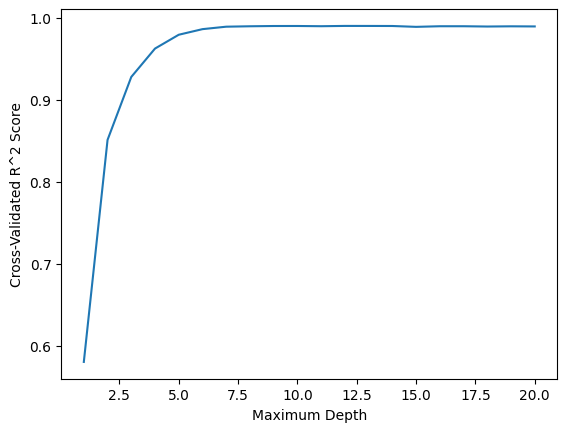

Best Maximum Depth: 12
Corresponding Cross-Validated R^2 Score: 0.9900012377299564


In [ ]:
# As we kow that for the tree based Decission Tree feature selection method required max_depth parameter.
# To get best max_depth for our data set we can use cross-validation technique and use that best max_depth

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

# Split the dataset into features (X) and target (y)
X = df_data_cleaned.drop(columns=[target_variable])
y = df_data_cleaned[target_variable]

# Create a decision tree regressor
tree = DecisionTreeRegressor()

# Define the range of maximum depths to test
max_depths = np.arange(1, 21)

# Compute the cross-validated R^2 scores for each maximum depth
scores = [cross_val_score(tree.set_params(max_depth=max_depth), X, y, cv=5, scoring='r2').mean() for max_depth in max_depths]

# Plot the cross-validated R^2 scores vs. maximum depth
import matplotlib.pyplot as plt
plt.plot(max_depths, scores)
plt.xlabel('Maximum Depth')
plt.ylabel('Cross-Validated R^2 Score')
plt.show()

# Print the best maximum depth and the corresponding score
best_index = np.argmax(scores)
best_max_depth = max_depths[best_index]
best_score = scores[best_index]
print(f'Best Maximum Depth: {best_max_depth}')
print(f'Corresponding Cross-Validated R^2 Score: {best_score}')

In [ ]:
#Based on the CV method we can say that best max_depth is 12. So let us use that and implement Tree based feature Selection

from sklearn.feature_selection import SelectFromModel

# Split the dataset into features (X) and target (y)
X = df_data_cleaned.drop(columns=[target_variable])
y = df_data_cleaned[target_variable]

# Create a decision tree regressor with optimal maximum depth
tree = DecisionTreeRegressor(max_depth=10)

# Perform feature selection using a decision tree model
selector = SelectFromModel(tree)
selector.fit(X, y)

# Print the selected features
selected_features = X.columns[selector.get_support()]
print(selected_features)

Index(['registered'], dtype='object')


Based on the above Features selection methods, we can conclude that the following are the best features for Model Building:

season, year, month, hr, weekday, working day, registered, unregisterd, weather condition and date.

But we are eliminating year parameter as we need to predict the target variable irrespective of year further.

In [ ]:
selected_features = ['season', 'month', 'hr', 'weekday', 'workingday', 'registered', 'unregistered' , 'date', 'weatherCondition', 'total_count']

df_data_featureSelected = df_data_cleaned[selected_features]
df_data_featureSelected

,season,month,hr,weekday,workingday,registered,unregistered,date,weatherCondition,total_count
0,2,1,0,6,1,13.0,3.0,1,1,16.0
1,2,1,1,6,1,32.0,8.0,1,1,40.0
3,2,1,3,6,1,10.0,3.0,1,1,13.0
4,2,1,4,6,1,1.0,0.0,1,1,1.0
5,2,1,5,6,1,1.0,0.0,1,4,1.0
...,...,...,...,...,...,...,...,...,...,...
17370,2,12,15,1,2,246.0,69.0,31,4,315.0
17373,2,12,18,1,2,112.0,10.0,31,4,122.0
17374,2,12,19,1,2,108.0,11.0,31,4,119.0
17375,2,12,20,1,2,81.0,8.0,31,4,89.0


Categorical Columns Encoding

In [ ]:
# Performing the oneHot Encoding for the categorical columns in features selected
from sklearn.preprocessing import OneHotEncoder
df_data_oneHot = df_data_featureSelected.copy()

cat_selected_features = ['season', 'month', 'weekday', 'workingday', 'weatherCondition']
onehot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
onehot_encoder.fit(df_data_oneHot[cat_selected_features])
encoded_cols = onehot_encoder.transform(df_data_oneHot[cat_selected_features])

# Add the encoded columns to the dataset
encoded_cols_df = pd.DataFrame(encoded_cols, columns=onehot_encoder.get_feature_names_out(cat_selected_features))
df_data_oneHot = pd.concat([df_data_oneHot, encoded_cols_df], axis=1)

# Drop the original categorical columns
df_data_oneHot.drop(cat_selected_features, axis=1, inplace=True)
df_data_oneHot.dropna(axis=0, inplace=True)
df_data_oneHot



,hr,registered,unregistered,date,total_count,season_1,season_2,season_3,season_4,month_1,...,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,workingday_2,weatherCondition_1,weatherCondition_2,weatherCondition_3,weatherCondition_4
0,0.0,13.0,3.0,1.0,16.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1.0,32.0,8.0,1.0,40.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
3,3.0,10.0,3.0,1.0,13.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
4,4.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
5,5.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17334,3.0,14.0,1.0,30.0,15.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
17335,4.0,7.0,0.0,30.0,7.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
17336,5.0,2.0,0.0,30.0,2.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
17337,6.0,7.0,1.0,30.0,8.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


Splitting dataset:

In [ ]:
# Splitting dataset

X_train, X_test, y_train, y_test = train_test_split(df_data_oneHot.drop('total_count', axis=1), df_data_oneHot['total_count'], test_size=0.2, random_state=42)

Feature Scalling:


We have majorly 2 methods for scalling the features.

1. Min-Max Scalling
2. Standardscalling

Let us perfrom both methods and use Random Regressor to get R2 value and finalise the method.




In [ ]:
# Method 1 : Min-Max Scalling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Perform min-max scaling on the training data
scaler_minmax = MinMaxScaler()
X_train_minmax = scaler_minmax.fit_transform(X_train)

# Train a SimpleRandomRegressor on the min-max scaled training data
model_minmax = RandomForestRegressor()
model_minmax.fit(X_train_minmax, y_train)

# Apply the same min-max scaling to the test data
X_test_minmax = scaler_minmax.transform(X_test)

# Evaluate the performance of the model on the test data
y_pred_minmax = model_minmax.predict(X_test_minmax)
r2_minmax = r2_score(y_test, y_pred_minmax)


In [ ]:
# Method 2 : Standard Scalling

# Perform standard scaling on the training data
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train)

# Train a SimpleRandomRegressor on the standard scaled training data
model_std = RandomForestRegressor()
model_std.fit(X_train_std, y_train)

# Apply the same standard scaling to the test data
X_test_std = scaler_std.transform(X_test)

# Evaluate the performance of the model on the test data
y_pred_std = model_std.predict(X_test_std)
r2_std = r2_score(y_test, y_pred_std)


In [ ]:

# Compare the performance of the two models
print("R-squared score for min-max scaled data:", r2_minmax)
print("R-squared score for standard scaled data:", r2_std)


R-squared score for min-max scaled data: 0.9962153310495825
R-squared score for standard scaled data: 0.9962307434998546


Based on the r2 we can say that both methods are good for our dataset. Since we have narrow range of values we can consider using standardScaler.



In [ ]:
print(X_train_std.shape)
print(y_train.shape)
print(X_test_std.shape)
print(y_test.shape)

(13844, 33)
(13844,)
(3462, 33)
(3462,)


In [ ]:
X_train_std

array([[ 1.65429898, -0.48933845, -0.23770163, ..., -0.01202031,
        -0.2945191 , -0.59270002],
       [ 0.64037988,  0.82201094,  0.99658112, ..., -0.01202031,
        -0.2945191 , -0.59270002],
       [-0.80807599, -0.5482755 , -0.86919513, ..., -0.01202031,
        -0.2945191 , -0.59270002],
       ...,
       [-1.09776717, -1.03450617, -0.89789938, ..., -0.01202031,
        -0.2945191 , -0.59270002],
       [ 1.65429898, -1.03450617, -0.81178663, ..., -0.01202031,
        -0.2945191 ,  1.68719414],
       [-1.67714951, -0.62194681, -0.72567388, ..., -0.01202031,
        -0.2945191 ,  1.68719414]])

Model Building:

# **1. RandomForest Regressor**

In [ ]:
# RandomForest Regressor 

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Create the GridSearchCV object
rf_model = RandomForestRegressor(random_state=42)

# Fit the model
rf_model.fit(X_train_std, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_std)

# calculate R2
r2_test = r2_score(y_test, y_pred)
print('r2 score for test data set: ',r2_test)

#calculate r2 for train set
y_train_pred = rf_model.predict(X_train_std)
r2_train = r2_score(y_train, y_train_pred)
print('R^2 score for training set: ', r2_train)

# Get model scores for both test and train sets

train = rf_model.score(X_train_std, y_train)
test = rf_model.score(X_test_std, y_test)
print('Model Score for train data: ', train)
print('Model Score for Test data: ', test)




r2 score for test data set:  0.9963756164572799
R^2 score for training set:  0.9994931884640043
Model Score for train data:  0.9994931884640043
Model Score for Test data:  0.9963756164572799


In [ ]:
# Let us perfrom GridsearchCV for RF


rf_model_cv = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [300, 320, 340,350, 500],
    'max_depth': [20,30, 40, None],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(rf_model_cv, param_grid=param_grid, cv=5, n_jobs = -1)
grid_search.fit(X_train_std, y_train)

# print the best hyperparameters for RF
print('Best hyperparameters for RF:', grid_search.best_params_)

# predict on the test set with the best model
best_rf_regressor = grid_search.best_estimator_
y_pred = best_rf_regressor.predict(X_test_std)

# calculate R^2 score for training set
y_train_pred = best_rf_regressor.predict(X_train_std)
r2_train_best_rf = r2_score(y_train, y_train_pred)
print('R^2 score for training set:', r2_train_best_rf)

# calculate R^2 score for test set
r2_test_best_rf = r2_score(y_test, y_pred)
print('R^2 score for test set:', r2_test_best_rf)

# Get model scores for both test and train sets

train_best_rf = best_rf_regressor.score(X_train_std, y_train)
test_best_rf = best_rf_regressor.score(X_test_std, y_test)
print('Model Score for train data: ', train_best_rf)
print('Model Score for Test data: ', test_best_rf)

Best hyperparameters for RF: {'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 320}
R^2 score for training set: 0.9986032074446934
R^2 score for test set: 0.9901066739525185
Model Score for train data:  0.9986032074446934
Model Score for Test data:  0.9901066739525185


## **2.Decission Tree Regressor**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor(random_state=42)
# fit the regressor with X_train_std and y_train
dt_model.fit(X_train_std, y_train)

# predict on the test set
y_pred = dt_model.predict(X_test_std)

# calculate R^2 score for training set
y_train_pred = dt_model.predict(X_train_std)
r2_train = r2_score(y_train, y_train_pred)
print('R^2 score for training set:', r2_train)

# calculate R^2 score for test set
r2_test = r2_score(y_test, y_pred)
print('R^2 score for test set:', r2_test)

# Get model scores for both test and train sets

train = dt_model.score(X_train_std, y_train)
test = dt_model.score(X_test_std, y_test)
print('Model Score for train data: ', train)
print('Model Score for Test data: ', test)

R^2 score for training set: 0.9999970273753803
R^2 score for test set: 0.9933599458067413
Model Score for train data:  0.9999970273753803
Model Score for Test data:  0.9933599458067413


In [ ]:
# It seems like the model is performing good but overfiting, which leads to poor perfromance for new or unseen data. Let us perfrom 
# HyperParameter Tuning using CV

from sklearn.model_selection import GridSearchCV

# create a Decision Tree Regressor object
dt_regressor = DecisionTreeRegressor(random_state=42)

# define the hyperparameter grid
param_grid = {'max_depth': [2, 4, 6, 8, 10],
              'min_samples_split': [2, 4, 6, 8],
              'min_samples_leaf': [1, 2, 4, 6, 8, 10]}

# create a GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(estimator=dt_regressor, param_grid=param_grid, cv=5, n_jobs = -1)

# fit the GridSearchCV object with X_train_std and y_train
grid_search.fit(X_train_std, y_train)

# print the best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)

# predict on the test set with the best model
best_dt_regressor = grid_search.best_estimator_
y_pred = best_dt_regressor.predict(X_test_std)

# calculate R^2 score for training set
y_train_pred = best_dt_regressor.predict(X_train_std)
r2_train_best_dt = r2_score(y_train, y_train_pred)
print('R^2 score for training set:', r2_train_best_dt)

# calculate R^2 score for test set
r2_test_best_dt = r2_score(y_test, y_pred)
print('R^2 score for test set:', r2_test_best_dt)

# Get model scores for both test and train sets

train_best_dt = best_dt_regressor.score(X_train_std, y_train)
test_best_dt = best_dt_regressor.score(X_test_std, y_test)
print('Model Score for train data: ', train_best_dt)
print('Model Score for Test data: ', test_best_dt)

Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
R^2 score for training set: 0.9963384641783647
R^2 score for test set: 0.9943548626411177
Model Score for train data:  0.9963384641783647
Model Score for Test data:  0.9943548626411177


## **3. Supprot Vector Regressor**

In [ ]:
from sklearn.svm import SVR

# Train an SVR model
svr_model = SVR(kernel='rbf', C=1, gamma='scale', epsilon=0.1) # taking default values
svr_model.fit(X_train_std, y_train)

# predict on the test set
y_pred = svr_model.predict(X_test_std)

# calculate R^2 score for training set
y_train_pred = svr_model.predict(X_train_std)
r2_train = r2_score(y_train, y_train_pred)
print('R^2 score for training set:', r2_train)

# calculate R^2 score for test set
r2_test = r2_score(y_test, y_pred)
print('R^2 score for test set:', r2_test)

# Get model scores for both test and train sets

train = svr_model.score(X_train_std, y_train)
test = svr_model.score(X_test_std, y_test)
print('Model Score for train data: ', train)
print('Model Score for Test data: ', test)


R^2 score for training set: 0.8710996200495477
R^2 score for test set: 0.8722275666771314
Model Score for train data:  0.8710996200495477
Model Score for Test data:  0.8722275666771314


## **4. K-Nearest Neighbors (KNN)**

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Train a KNN regression model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_std, y_train)

# predict on the test set
y_pred = knn_model.predict(X_test_std)

# calculate R^2 score for training set
y_train_pred = knn_model.predict(X_train_std)
r2_train = r2_score(y_train, y_train_pred)
print('R^2 score for training set:', r2_train)

# calculate R^2 score for test set
r2_test = r2_score(y_test, y_pred)
print('R^2 score for test set:', r2_test)

# Get model scores for both test and train sets

train = knn_model.score(X_train_std, y_train)
test = knn_model.score(X_test_std, y_test)
print('Model Score for train data: ', train)
print('Model Score for Test data: ', test)


R^2 score for training set: 0.9426287566955748
R^2 score for test set: 0.8927992759865775
Model Score for train data:  0.9426287566955748
Model Score for Test data:  0.8927992759865775


In [ ]:
# although the model is performing well, there is difference between test and train set performance. 
# Let us check with CV 

from sklearn.model_selection import GridSearchCV


param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
}

# Create a KNN regressor object
knn_cv = KNeighborsRegressor()

# Create a GridSearchCV object with 5-fold cross validation
grid_search = GridSearchCV(estimator=knn_cv, param_grid=param_grid, cv=5, scoring='r2')

# Fit the grid search object to the standardized training data
grid_search.fit(X_train_std, y_train)

print("Best Hyperparameters: ", grid_search.best_params_)

# predict on the test set
y_pred = grid_search.predict(X_test_std)

# calculate R^2 score for training set
y_train_pred = grid_search.predict(X_train_std)
r2_train = r2_score(y_train, y_train_pred)
print('R^2 score for training set:', r2_train)

# calculate R^2 score for test set
r2_test = r2_score(y_test, y_pred)
print('R^2 score for test set:', r2_test)

# Get model scores for both test and train sets

train = grid_search.score(X_train_std, y_train)
test = grid_search.score(X_test_std, y_test)
print('Model Score for train data: ', train)
print('Model Score for Test data: ', test)

Best Hyperparameters:  {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
R^2 score for training set: 0.9999970273753802
R^2 score for test set: 0.925137907062616
Model Score for train data:  0.9999970273753802
Model Score for Test data:  0.925137907062616


# **5. XGBoost**

In [ ]:
import xgboost as xgb

# Define the XGBoost model and set hyperparameters
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=150,
    max_depth=30,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.8
)

# Train the XGBoost model on the standardized training data
xgb_model.fit(X_train_std, y_train)

# Make predictions on the standardized test data
y_pred = xgb_model.predict(X_test_std)

# calculate R^2 score for training set
y_train_pred = xgb_model.predict(X_train_std)
r2_train = r2_score(y_train, y_train_pred)
print('R^2 score for training set:', r2_train)

# calculate R^2 score for test set
r2_test = r2_score(y_test, y_pred)
print('R^2 score for test set:', r2_test)

# Get model scores for both test and train sets

train = xgb_model.score(X_train_std, y_train)
test = xgb_model.score(X_test_std, y_test)
print('Model Score for train data: ', train)
print('Model Score for Test data: ', test)

R^2 score for training set: 0.9999187398992485
R^2 score for test set: 0.9962044191630905
Model Score for train data:  0.9999187398992485
Model Score for Test data:  0.9962044191630905


In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the XGBRegressor model
xgb_model = xgb.XGBRegressor()

# Define the hyperparameter grid to search over
params = {
    "max_depth": [ 4, 5, 8],
    "learning_rate": [0.1],
    "n_estimators": [300, 500, 700]
}

# Initialize the GridSearchCV object with 5-fold cross-validation
xgb_grid = GridSearchCV(estimator=xgb_model, param_grid=params, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the training data
xgb_grid.fit(X_train_std, y_train)
# Make predictions on the standardized test data
y_pred = xgb_grid.predict(X_test_std)

# calculate R^2 score for training set
y_train_pred = xgb_grid.predict(X_train_std)
r2_train_xgb = r2_score(y_train, y_train_pred)
print('R^2 score for training set:', r2_train_xgb)

# calculate R^2 score for test set
r2_test_xgb = r2_score(y_test, y_pred)
print('R^2 score for test set:', r2_test_xgb)

# Get model scores for both test and train sets

# Print the best hyperparameters and the corresponding mean test score
print("Best hyperparameters:", xgb_grid.best_params_)
train_xgb = xgb_grid.score(X_train_std, y_train)
test_xgb = xgb_grid.score(X_test_std, y_test)
print('Model Score for train data: ', train_xgb)
print('Model Score for Test data: ', test_xgb)

R^2 score for training set: 0.9986792934425391
R^2 score for test set: 0.9970846921704682
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500}
Model Score for train data:  0.9986792934425391
Model Score for Test data:  0.9970846921704682


## **6. Linear Regression**

In [ ]:
from sklearn.linear_model import LinearRegression

# Create a LinearRegression object
lr_model = LinearRegression()

# Train the model on the training data
lr_model.fit(X_train_std, y_train)

# Make predictions on the test data
y_pred = lr_model.predict(X_test_std)

# calculate R^2 score for training set
y_train_pred = lr_model.predict(X_train_std)
r2_train = r2_score(y_train, y_train_pred)
print('R^2 score for training set:', r2_train)

# calculate R^2 score for test set
r2_test = r2_score(y_test, y_pred)
print('R^2 score for test set:', r2_test)

# Get model scores for both test and train sets

train = lr_model.score(X_train_std, y_train)
test = lr_model.score(X_test_std, y_test)
print('Model Score for train data: ', train)
print('Model Score for Test data: ', test)

R^2 score for training set: 0.9868621996041695
R^2 score for test set: 0.9876214648473436
Model Score for train data:  0.9868621996041695
Model Score for Test data:  0.9876214648473436


# **7. Lasso Regression**

In [ ]:
# As we perfromed best alpha for Lasso with our dataset earlier, considering it for model building

from sklearn.linear_model import Lasso

# Create a Lasso object
ls_model = Lasso(alpha=0.29)

# Train the model on the training data
ls_model.fit(X_train_std, y_train)

# Make predictions on the test data
y_pred = ls_model.predict(X_test_std)

# calculate R^2 score for training set
y_train_pred = ls_model.predict(X_train_std)
r2_train = r2_score(y_train, y_train_pred)
print('R^2 score for training set:', r2_train)

# calculate R^2 score for test set
r2_test = r2_score(y_test, y_pred)
print('R^2 score for test set:', r2_test)

# Get model scores for both test and train sets

train = ls_model.score(X_train_std, y_train)
test = ls_model.score(X_test_std, y_test)
print('Model Score for train data: ', train)
print('Model Score for Test data: ', test)

R^2 score for training set: 0.986793942195593
R^2 score for test set: 0.9875741619311929
Model Score for train data:  0.986793942195593
Model Score for Test data:  0.9875741619311929


# **8. Elastic Net**

In [ ]:
from sklearn.linear_model import ElasticNet

# Create an Elastic Net object
en_model = ElasticNet(alpha=0.29, l1_ratio=0.5)

# Train the model on the training data
en_model.fit(X_train_std, y_train)

# Make predictions on the test data
y_pred = en_model.predict(X_test_std)

# calculate R^2 score for training set
y_train_pred = en_model.predict(X_train_std)
r2_train = r2_score(y_train, y_train_pred)
print('R^2 score for training set:', r2_train)

# calculate R^2 score for test set
r2_test = r2_score(y_test, y_pred)
print('R^2 score for test set:', r2_test)

# Get model scores for both test and train sets

train = en_model.score(X_train_std, y_train)
test = en_model.score(X_test_std, y_test)
print('Model Score for train data: ', train)
print('Model Score for Test data: ', test)

R^2 score for training set: 0.973625422779669
R^2 score for test set: 0.9759169498085302
Model Score for train data:  0.973625422779669
Model Score for Test data:  0.9759169498085302


Based on above Algorithms and there performances we can say that almost all models are perfroming well as we did Feature Selection, Scalling, Regularization etc.. for the data prior to model building.

Among all the models, let us consider Xgboost Regressor as final model as it perfromed well after cross validation.

Sice we got approximately same score value for both Test and Train data, we dont need to perfrom hyperparameter Tuning further.

In [ ]:
print("Best hyperparameters:", xgb_grid.best_params_)
print('R^2 score for training set:', r2_train_xgb)
print('R^2 score for test set:', r2_test_xgb)
print('Model Score for train data: ', train_xgb)
print('Model Score for Test data: ', test_xgb)

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500}
R^2 score for training set: 0.9986792934425391
R^2 score for test set: 0.9970846921704682
Model Score for train data:  0.9986792934425391
Model Score for Test data:  0.9970846921704682


In [ ]:
# let us create a X_train and y_train after feature selection for the use of pipeline and deployment

X_train_p, X_test_p, y_train, y_test = train_test_split(df_data_featureSelected.drop('total_count', axis=1), df_data_featureSelected['total_count'], test_size=0.2, random_state=42)

In [ ]:
X_train_p

,season,month,hr,weekday,workingday,registered,unregistered,date,weatherCondition
1412,2,3,3,5,2,1.0,0.0,3,4
16961,4,12,12,5,2,244.0,29.0,14,1
13667,1,7,16,6,1,279.0,114.0,28,1
12695,3,6,4,1,2,9.0,0.0,18,4
14504,1,9,13,6,1,267.0,114.0,9,4
...,...,...,...,...,...,...,...,...,...
11300,3,4,1,6,1,64.0,24.0,21,1
11980,3,5,9,6,1,213.0,79.0,19,1
5406,1,8,4,4,2,9.0,0.0,18,1
876,2,2,23,2,2,9.0,3.0,2,1


### **Deployment**

In [ ]:
# Creating a pipeline for the preprocessing, scalling, modeling etc..


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib



# Define the column transformer for the categorical features
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('cat', categorical_transformer, ['season', 'month', 'weekday', 'workingday', 'weatherCondition'])],
                                 remainder='passthrough')


# Define the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('scaler', StandardScaler(with_mean=False)),
                           ('regressor', xgb.XGBRegressor(learning_rate=0.1, max_depth=4, n_estimators=500))])

# Fit the pipeline on the training data
pipeline.fit(X_train_p, y_train)

# Save model to disk
filename = 'model.pkl'
joblib.dump(pipeline, filename)

['model.pkl']

In [ ]:
from google.colab import files

# Download the model.pkl file
files.download('model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>